# Introduction to GANs

Generative Adversarial Networks (GANs) are a powerful deep learning architecture for generating new, previously unseen data. They consist of two networks: a generator and a discriminator. The generator tries to generate new data that is similar to a training dataset, while the discriminator tries to determine whether each piece of data is real or fake. The two networks are trained together, with the generator producing new data and the discriminator trying to distinguish real from fake. 

As training progresses, the generator becomes better at creating realistic data, and the discriminator becomes better at distinguishing real from fake. 

In this example, we will be using the CIFAR10 dataset, which consists of 60,000 32x32 color training images and 10,000 test images, labeled over 10 categories.

We will be generating 1000 small colour images.

## Advantages and Disadvantages of GANs

[Credit](https://arxiv.org/abs/1701.00160)

In summary, GANs were designed to avoid many disadvantages associated with

other generative models:

- They can generate samples in parallel, instead of using runtime proportional to the dimensionality of x. This is an advantage relative to FVBNs.
- The design of the generator function has very few restrictions. This is an advantage relative to Boltzmann machines, for which few probability distributions admit tractable Markov chain sampling, and relative to non-linear ICA, for which the generator must be invertible and the latent code z must have the same dimension as the samples x.
- No Markov chains are needed. This is an advantage relative to Boltzmann

machines and GSNs.

- No variational bound is needed, and specific model families usable within the GAN framework are already known to be universal approximators, so GANs are already known to be asymptotically consistent. Some VAEs are conjectured to be asymptotically consistent, but this is not yet proven.
- GANs are subjectively regarded as producing better samples than other methods.

At the same time, GANs have taken on a new disadvantage: training them requires finding the Nash equilibrium of a game, which is a more difficult problem than optimizing an objective function.

## Conditional vs Unconditional GANs
There are two main types of GANs: conditional GANs and unconditional GANs.

**Unconditional GANs (uGANs)** are GANs that do not use any additional input information beyond the training dataset to generate synthetic data samples. The generator model is trained to learn the underlying distribution of the data and generate synthetic samples that are similar to the real data.

**Conditional GANs (cGANs)** are GANs that use additional input information, such as class labels or images, to generate synthetic data samples that are conditioned on this input. For example, a cGAN could be used to generate synthetic images of a particular type of object (e.g., cats) by providing the class label "cat" as input to the generator model.

Both unconditional GANs and conditional GANs have a wide range of applications, including data augmentation, missing data imputation, image generation, and more. 

Unconditional GANs are often used when the goal is to generate synthetic data samples that are similar to the real data, without any specific constraints or conditions. 

Conditional GANs are often used when the goal is to generate synthetic data samples that are conditioned on specific input information or meet certain constraints.

Overall, the choice between using an unconditional GAN or a conditional GAN will depend on the specific application and the goals of the model. Both types of GANs have their own advantages and disadvantages, and the appropriate choice will depend on the nature of the data and the task at hand.

In this case, we will be using a conditional GAN combined with one-sided label smoothing. We will delve more into one-sided label smoothing later in the notebook.

## Ensuring Lipschitz Continuity
In a generative adversarial network (GAN), being Lipschitz continuous means that the output of the model should change smoothly as the input changes. A Lipschitz continuous function is a function that satisfies the Lipschitz condition, which states that the function has a bounded derivative.

In the context of a GAN, the discriminator model is typically trained to be Lipschitz continuous in order to stabilize the training process and improve the quality of the generated synthetic data. This can be achieved by adding a gradient penalty term to the loss function of the discriminator model, which encourages the model to change smoothly as the input changes.

Overall, being Lipschitz continuous can help prevent model collapsing in a GAN and improve the performance of the model by stabilizing the training process and generating synthetic data samples that are more realistic and representative of the real data.

## Weight Clipping
Weight clipping is a technique used to stabilize the training of generative adversarial networks (GANs). It involves "clipping" the weights of the discriminator network to a fixed range (e.g., [-0.01, 0.01]) to prevent them from becoming too large or too small.

The basic idea behind weight clipping is to prevent the discriminator network from becoming too powerful, which can lead to instability in the GAN training process. When the weights of the discriminator network are allowed to become too large, the network can become overly confident in its predictions and stop learning effectively. This can lead to oscillations and other forms of instability in the training process.

Weight clipping can help to prevent these issues by limiting the range of values that the weights of the discriminator network can take on. This can help to stabilize the training process and improve the performance of the GAN.

## Managing Mode Collapse
Mode collapse is a problem that can occur in training generative adversarial networks (GANs), where the generator learns to produce a limited number of distinct samples, rather than producing a diverse range of samples that capture the full diversity of the training data. This can result in the generator producing repetitive or unrealistic samples, and can lead to poor performance of the GAN.

There are a few ways to prevent mode collapse in GANs:

1. One option is to use a non-saturating loss function for the generator and discriminator. Non-saturating loss functions, such as the minimax loss or the least squares loss, are less prone to saturating, which can help to prevent the generator from collapsing to a single mode.
2. Another option is to use a diversity-promoting objective for the generator, such as the Wasserstein distance or the maximum mean discrepancy (MMD). These objectives encourage the generator to produce a wide range of diverse samples

# Imports

In [4]:
!nvidia-smi

Sat Jan 28 16:38:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:16:00.0 Off |                    0 |
| N/A   

In [4]:
# imports

from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import time
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for i in physical_devices:
    tf.config.experimental.set_memory_growth(i, True)
        
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU, LayerNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import utils 
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from IPython.display import clear_output
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from numpy import asarray
from tensorflow.keras.applications import InceptionV3
from scipy.stats import entropy
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
# !pip install tensorflow-gpu==2.2.0

In [3]:
!pip install torchmetrics
!pip install torch-fidelity
!pip install --upgrade typing-extensions
!pip install torchvision

  Using cached torchmetrics-0.11.0-py3-none-any.whl (512 kB)
  Using cached torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached torch_fidelity-0.3.0-py3-none-any.whl (37 kB)
  Using cached torchvision-0.14.1-cp38-cp38-manylinux1_x86_64.whl (24.2 MB)
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.2
    Uninstalling typing-extensions-3.7.4.2:
      Successfully uninstalled typing-extensions-3.7.4.2


In [3]:
from tensorflow.python.client import device_lib


print(device_lib.list_local_devices())


import torch
torch.cuda.empty_cache()




[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 690687951523677609
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6295694181872903381
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11850035788150394820
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31741994624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16152028714364086344
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"
]


# Data Ingestion

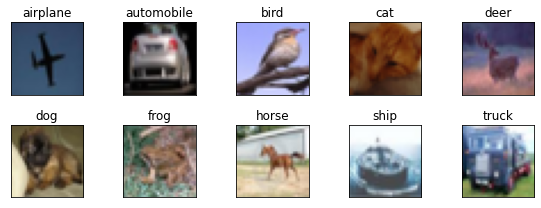

In [10]:
# load the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train_fid = np.copy(X_train)
X_test_fid = np.copy(X_test)
y_train_reverse = np.copy(y_train)
y_test_reverse = np.copy(y_test)


num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [121]:
y_train_reverse.shape

(50000, 1)

# Data Normalisation


In [11]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('y train shape:',y_train.shape)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
print(np.ptp(X_train))
X_train = ((X_train / 255) - 0.5) * 2
print(np.ptp(X_train))


# X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
# X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_train_fid reshape:', X_train_fid.shape)
print('X_test reshape:', X_test.shape)
print('X_test_fid reshape:', X_test_fid.shape)


CSNGAN = tf.data.Dataset.from_tensor_slices((X_train,y_train_reverse)).batch(128)
X_train = tf.data.Dataset.from_tensor_slices((X_train)).batch(128)
X_test = tf.data.Dataset.from_tensor_slices((X_test)).batch(128)



# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y train shape: (50000, 10)
255.0
2.0
X_train reshape: (50000, 32, 32, 3)
X_train_fid reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)
X_test_fid reshape: (10000, 32, 32, 3)


# Approach in GAN Creation

We will be exploring different methods and techniques in optimising and improving GAN performance.


1. **Gradient Penalty** - We will be using gradient penalty in the discriminator model. This to encourage the discriminator network to be smooth and well-behaved.
2. **One-sided Label Smoothing** - We will be using one-sided label smoothing in the discriminator model. This will reduce the gap between the "hard" labels and the model's predictions.
3. **Virtual Batch Normalisation** - We will be using virtual batch normalisation to improve stability, performance, and to reduce the memory requirements of the model.
4. **Non-Saturating Loss Function** - We will be using non-saturating loss function in the discriminator model. it has been observed that using the binary cross-entropy loss can lead to the discriminator becoming too powerful, and the generator being unable to learn.



## Gradient Penalty
In GANs, the gradient penalty is a *regularization term* that is added to the loss function of the discriminator network. It helps to improve the stability of the GAN training process and can also improve the quality of the generated samples.

The basic idea behind the gradient penalty is to encourage the discriminator network to be smooth and well-behaved, rather than exhibiting sharp changes in its output. This is accomplished by penalizing the discriminator network for producing large gradients with respect to its inputs.

To implement the gradient penalty, the GAN training process computes the gradient of the discriminator network's output with respect to its input (i.e., the samples), and then penalizes the discriminator network based on the magnitude of the gradients. 

This encourages the discriminator network to produce smooth, predictable outputs, rather than exhibiting sharp changes that can be difficult for the generator network to model.

We will be looking at a Wasserstein GAN, implemented with Gradient Penalty, resulting in a WGAN-GP. By implementing the gradient penalty, we can ensure that the GAN is Lipschitz continuous. 

This is also an alternative to using weight clipping, which can be used to stabilize the training process of a GAN.

Advantages include more stable training and little hyperparameter tuning.

In [8]:
def gradientPenalty(generator, noise, real_image, epsilon, LAMBDA, discriminator, D_optimizer, d_tape, gp_tape,):
    with tf.GradientTape(persistent=True) as d_tape:
            with tf.GradientTape() as gp_tape:
                fake_image = generator([noise], training=True)
                fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
                fake_mixed_pred = discriminator([fake_image_mixed], training=True)
                
            # Compute gradient penalty
            grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
            grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
            gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
            
            fake_pred = discriminator([fake_image], training=True)
            real_pred = discriminator([real_image], training=True)
            
            D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))

## One-Sided Label Smoothing
Label smoothing is a technique used to improve the stability and performance of generative adversarial networks (GANs). It works by replacing the "hard" labels (i.e., 0 for fake samples and 1 for real samples) used to train the discriminator network with "smooth" labels that are slightly less extreme.

There are two main types of label smoothing:

1. Normal label smoothing: In normal label smoothing, the labels for fake samples are replaced with a value less than 0 (e.g., -0.1) and the labels for real samples are replaced with a value greater than 1 (e.g., 1.1). The amount of smoothing is typically controlled by a smoothing parameter (e.g., 0.1).

2. One-sided label smoothing: In one-sided label smoothing, only the labels for real samples are smoothed. The labels for fake samples are still set to 0, while the labels for real samples are set to a value less than 1 (e.g., 0.9).

The purpose of using label smoothing is to reduce the gap between the "hard" labels and the model's predictions, which can help to reduce overconfidence and improve the stability of the model. It can also help to improve the performance of the model by encouraging the model to be more uncertain about its predictions.

One-sided label smoothing can be *especially useful for GANs*, because it allows the discriminator network to continue to focus on distinguishing fake samples from real samples, while also encouraging it to be less certain about its predictions for real samples. 

This can help to improve the stability of the model and the quality of the generated samples.

We will doing a custom implementation of OLS by referencing this algorithm by (Zhang et al., 2021)

Credit: Zhang, C.-B., Jiang, P.-T., Hou, Q., Wei, Y., Han, Q., Li, Z. and Cheng, M.-M. (2021). Delving Deep Into Label Smoothing. IEEE Transactions on Image Processing, [online] 30, pp.5984–5996. doi:10.1109/tip.2021.3089942.

For this case, I will be doing Adaptive OLS, sampling from a normal distribution and augmenting the labels on the fly.

In [12]:
def OLS(b_size):
    real_labels = np.ones((b_size,1))
    mean = 0
    std = 0.1
    s = np.random.normal(mean, std, b_size)
    smooth_labels = (real_labels - s.reshape(b_size,1)).clip(0, 0.99999)
    return smooth_labels

ols = OLS(128)
print(np.ones((128,1)).shape)
print(ols.shape)

(128, 1)
(128, 1)


## Spectral Normalisation
Spectral normalization is a technique used to stabilize the training of generative models, such as Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs). It is used to constrain the Lipschitz constant of the generator's network mapping function to be 1, which helps to prevent the generator from producing unrealistic outputs and improves the stability of the training process. 

Spectral normalization is performed by normalizing the weight matrix of a particular layer in the generator network based on its largest singular value (i.e., the spectral norm) and scaling the weight matrix down by that value. This helps to ensure that the generator's output is within a reasonable range, making it easier to optimize the model and improve its performance.

In [13]:
# adapted from tensorflow_addons
from typeguard import typechecked

class SpectralNormalization(tf.keras.layers.Wrapper):
    """Performs spectral normalization on weights.

    This wrapper controls the Lipschitz constant of the layer by
    constraining its spectral norm, which can stabilize the training of GANs.

    See [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957).

    Wrap `tf.keras.layers.Conv2D`:

    >>> x = np.random.rand(1, 10, 10, 1)
    >>> conv2d = SpectralNormalization(tf.keras.layers.Conv2D(2, 2))
    >>> y = conv2d(x)
    >>> y.shape
    TensorShape([1, 9, 9, 2])

    Wrap `tf.keras.layers.Dense`:

    >>> x = np.random.rand(1, 10, 10, 1)
    >>> dense = SpectralNormalization(tf.keras.layers.Dense(10))
    >>> y = dense(x)
    >>> y.shape
    TensorShape([1, 10, 10, 10])

    Args:
      layer: A `tf.keras.layers.Layer` instance that
        has either `kernel` or `embeddings` attribute.
      power_iterations: `int`, the number of iterations during normalization.
    Raises:
      AssertionError: If not initialized with a `Layer` instance.
      ValueError: If initialized with negative `power_iterations`.
      AttributeError: If `layer` does not has `kernel` or `embeddings` attribute.
    """

    @typechecked
    def __init__(self, layer: tf.keras.layers, power_iterations: int = 1, **kwargs):
        super().__init__(layer, **kwargs)
        if power_iterations <= 0:
            raise ValueError(
                "`power_iterations` should be greater than zero, got "
                "`power_iterations={}`".format(power_iterations)
            )
        self.power_iterations = power_iterations
        self._initialized = False

    def build(self, input_shape):
        """Build `Layer`"""
        super().build(input_shape)
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(shape=[None] + input_shape[1:])

        if hasattr(self.layer, "kernel"):
            self.w = self.layer.kernel
        elif hasattr(self.layer, "embeddings"):
            self.w = self.layer.embeddings
        else:
            raise AttributeError(
                "{} object has no attribute 'kernel' nor "
                "'embeddings'".format(type(self.layer).__name__)
            )

        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False,
            name="sn_u",
            dtype=self.w.dtype,
        )

    def call(self, inputs, training=None):
        """Call `Layer`"""
        if training is None:
            training = tf.keras.backend.learning_phase()

        if training:
            self.normalize_weights()

        output = self.layer(inputs)
        return output

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(self.layer.compute_output_shape(input_shape).as_list())

    def normalize_weights(self):
        """Generate spectral normalized weights.

        This method will update the value of `self.w` with the
        spectral normalized value, so that the layer is ready for `call()`.
        """

        w = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u = self.u

        with tf.name_scope("spectral_normalize"):
            for _ in range(self.power_iterations):
                v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
                u = tf.math.l2_normalize(tf.matmul(v, w))
            u = tf.stop_gradient(u)
            v = tf.stop_gradient(v)
            sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)
            self.u.assign(tf.cast(u, self.u.dtype))
            self.w.assign(
                tf.cast(tf.reshape(self.w / sigma, self.w_shape), self.w.dtype)
            )

    def get_config(self):
        config = {"power_iterations": self.power_iterations}
        base_config = super().get_config()
        return {**base_config, **config}
    
def spectral_norm_wrapper(layer, spectral_norm):
    if spectral_norm:
        return SpectralNormalization(layer)
    else:
        return layer

## Non-Saturating Loss Function
The binary cross-entropy loss is often used as the loss function for the discriminator in a GAN. However, it has been observed that using the binary cross-entropy loss can lead to the *discriminator becoming too powerful*, and the generator being unable to learn. 

This is because the binary cross-entropy loss saturates when the predicted probability is close to 0 or 1, which means that the gradients at these extremes are close to 0. This can prevent the generator from learning, as it relies on the gradients from the discriminator to update its weights.

To address this issue, some researchers have suggested using a non-saturating loss function for the discriminator, such as the `least-squares loss` or the `hinge loss`. These loss functions do not saturate, and as a result, the gradients remain large even when the predicted probability is close to 0 or 1. 

This can help the generator learn more effectively, as it receives stronger gradients from the discriminator throughout training.

In [ ]:
h = tf.keras.losses.Hinge()
h

## Adaptive Augmentation


In [14]:
import tensorflow.keras as keras

# "hard sigmoid", useful for binary accuracy calculation from logits
def step1(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))

# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(
        self, target_accuracy, integration_steps, max_probability, input_shape
    ):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        self.target_accuracy = target_accuracy
        self.integration_steps = integration_steps
        self.max_probability = max_probability

        max_translation = 0.125
        max_rotation = 0.125
        max_zoom = 0.25

        # the corresponding augmentation names from the paper are shown above each layer
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                # blitting/x-flip:
                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                # blitting/integer translation:
                tf.keras.layers.experimental.preprocessing.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                tf.keras.layers.experimental.preprocessing.RandomRotation(factor=max_rotation),
                
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        batch_size = tf.shape(images)[0]

        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step1(real_logits))

        # the augmentation probability is updated based on the dicriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - self.target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / self.integration_steps,
                0.0,
                self.max_probability,
            )
        )

# Evaluating GAN Performance
Evaluating the performance of a Generative Adversarial Network (GAN) is an important step in the development process because it allows you to assess how well the model is able to generate synthetic data that is similar to the training data. There are several ways to evaluate the performance of a GAN, including:

1. Qualitative evaluation: This involves visually inspecting the generated samples to see how similar they are to the training data.

2. Quantitative evaluation: This involves using metrics such as the Inception Score or the Fréchet Inception Distance (FID) to measure the similarity between the generated samples and the training data.

Inception score, kernel inception distance, and Fréchet inception distance are all evaluation metrics that can be used to measure the quality of synthetic data generated by a generative adversarial network (GAN) or other type of generative model.

Testing the model on downstream tasks: Another way to evaluate the performance of a GAN is to use the generated samples to train another machine learning model and see how well it performs on a specific task.

Overall, the goal of evaluating a GAN is to determine whether it is able to generate synthetic data that is of high quality and can be used for various tasks.

In [9]:
!pip install -U --no-deps pyiqa
!pip install opencv-python==4.2.0.34
!pip install imgaug
!pip install einops==0.3.0
!pip install timm==0.6.12
!pip install -U --no-deps pytorch-gan-metrics


  Using cached pyiqa-0.1.5-py3-none-any.whl (191 kB)
  Using cached opencv_python-4.2.0.34-cp38-cp38-manylinux1_x86_64.whl (28.2 MB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pyiqa 0.1.5 requires addict, which is not installed.
pyiqa 0.1.5 requires einops, which is not installed.
pyiqa 0.1.5 requires imgaug, which is not installed.
pyiqa 0.1.5 requires lmdb, which is not installed.
pyiqa 0.1.5 requires tb-nightly, which is not installed.
pyiqa 0.1.5 requires timm, which is not installed.
pyiqa 0.1.5 requires yapf, which is not installed.
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached shapely-2.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
ERROR: After October 2020 you may experience error

  Using cached pytorch_gan_metrics-0.5.2-py3-none-any.whl (18 kB)


In [7]:
import torch
from PIL import Image
from pytorch_gan_metrics import get_inception_score_from_directory
import pyiqa
torch.cuda.empty_cache()


## Inception Score

$$ IS = \exp\left(\mathbb{E}{x \sim p{data}}\left[KL\left(p(y|x)|p(y)\right)\right]\right) $$

The inception score (IS) is a metric that measures the quality of synthetic images generated by a GAN or other generative model. The IS is based on the output of an image classification model, called the Inception model, which is trained to classify images into a set of predefined categories. The IS is calculated as the average KL divergence between the predicted class probabilities for the synthetic images and a uniform distribution, with a higher score indicating higher quality images.

In [8]:
%%time

torch.cuda.empty_cache()
IS, IS_std = get_inception_score_from_directory(
    'datasets/test')


print('IS Mean: {:.5f}'.format(IS), '\nIS Std.Dev: {:.5f}'.format(IS_std))

IS Mean: 10.96652 
IS Std.Dev: 0.30116
CPU times: user 21.4 s, sys: 12 s, total: 33.4 s
Wall time: 46.7 s


As we can see, the baseline Inception score for the test dataset is around 10.96652, and the baseline standard deviation is 0.301.


This means that we strive to achieve a Inception score around 7-8, given that the training dataset is used to train our GAN.

A good GAN implementation on paperswithcode.com lie above 8 for Inception Score.

## Fréchet inception distance (FID)

$$FID(x, G) = ||\mu_x - \mu_G||^2 + Tr(\Sigma_x + \Sigma_G - 2(\Sigma_x \Sigma_G)^\frac{1}{2})$$


The Fréchet inception distance (FID) is a metric that measures the distance between the distributions of real and synthetic images in feature space. The FID is calculated using the Fréchet distance, which is a measure of the similarity between two multivariate distributions. A lower FID score indicates that the real and synthetic images are more similar, while a higher FID score indicates that they are more dissimilar.

In [9]:
%%time



fid_metric = pyiqa.create_metric('fid')
score = fid_metric('datasets/train', 'datasets/test')
print('FID: {:.5f}'.format(score))

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth



FID train:   0%|          | 0/1563 [00:00<?, ?it/s]

Found 50000 images in the folder datasets/train


FID train:  78%|███████▊  | 1219/1563 [01:45<00:29, 11.54it/s]


KeyboardInterrupt: 

As we can see, the baseline FID score between the train and test dataset is around 3.23.

This means that we strive to achieve a FID score around 3.23, given that the training dataset is used to train our GAN.

A good GAN implementation on paperswithcode.com lie below 15 for FID Score.

# Model Exploration


## Setup and Hyperparameters

Setting up training checkpoints and image saving

In [15]:
# Hyperparameters
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.layers as layers
# from tensorflow_addons.layers import SpectralNormalization
TARGET_IMG_SIZE = 32 # Scale images to this size
BATCH_SIZE = 128
image_size = 32
NOISE_DIM = 128
LAMBDA = 10 # For gradient penalty

EPOCHS = 10000
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 15 # Save checkpoint at every n epoch

N_CRITIC = 5 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.000001 # Minimum value of learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor



def checkpoint(generator, discriminator, G_optimizer, D_optimizer):
    '''
    Save checkpoint of model
    '''

    checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

    ckpt = tf.train.Checkpoint(generator=generator,
                            discriminator=discriminator,
                            G_optimizer=G_optimizer,
                            D_optimizer=D_optimizer)
    global ckpt_manager
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    # if a checkpoint exists, restore the latest checkpoint.
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
        CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
        print ('Latest checkpoint of epoch {} restored!'.format(CURRENT_EPOCH))
        print('Current Epoch', CURRENT_EPOCH)
        return CURRENT_EPOCH
    else:
        return 0


def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    '''
        Calculate new learning rate using decay factor
    '''
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr, D_optimizer, G_optimizer):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

def generate_and_save_images(model, epoch, test_input, figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=False):
    '''
        Generate images and plot it.
    '''
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, 32, 32, 3).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    if show_fig==True:
        plt.show()
    else:
        plt.close()

def calculate_scores(model, test_input,model_name,epoch):
    torch.cuda.empty_cache()
    images = (model.predict(test_input))
    images = ((images / 2) - 0.5) * 255
    images = images.astype(np.uint8)
    for i in range (images.shape[0]):
        im = Image.fromarray(images[i])
        im.save(f"{SINGLE_IMAGE_DIR}/epoch_{epoch}_image_{i}.png")
        
    
    IS_Mean, IS_std = get_inception_score_from_directory(f'datasets/{model_name}')
    IS_Mean = round(IS_Mean,5)
    IS_StdDev = round(IS_std,5)
    fid_metric = pyiqa.create_metric('fid')
    FID_value = fid_metric('datasets/test', f"datasets/{model_name}")
    FID_value = round(FID_value,5)


    return (IS_Mean,IS_StdDev, FID_value)
    
        
        
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
    return asarray(images_list)


def save_training(EPOCH_DIR_, DISC_LOSS_DIR_, GEN_LOSS_DIR_, IS_MEAN_DIR_, IS_STDDEV_DIR_, FID_DIR_, 
                  epoch,D_loss, G_loss, IS_mean, IS_stddev, FID_value):
    
    if not os.path.exists(os.path.join(EPOCH_DIR_, "epoch.txt")):
        open(os.path.join(EPOCH_DIR_, "epoch.txt"), "w").close()
    
    with open(os.path.join(EPOCH_DIR_, "epoch.txt"), "a") as file_object:
        file_object.write('epoch '+ str(epoch)+': '+ str(epoch)+'\n')
        
    if not os.path.exists(os.path.join(DISC_LOSS_DIR_, "disc_loss.txt")):
        open(os.path.join(DISC_LOSS_DIR_, "disc_loss.txt"), "w").close()    
        
    with open(os.path.join(DISC_LOSS_DIR_, "disc_loss.txt"), "a") as file_object:
        file_object.write('epoch '+ str(epoch)+': ' + str(D_loss.numpy())+'\n')
        
    if not os.path.exists(os.path.join(GEN_LOSS_DIR_, "gen_loss.txt")):
        open(os.path.join(GEN_LOSS_DIR_, "gen_loss.txt"), "w").close() 
        
    with open(os.path.join(GEN_LOSS_DIR_, "gen_loss.txt"), "a") as file_object:
        file_object.write('epoch '+ str(epoch)+': ' +str(G_loss.numpy())+'\n')
        
    if not os.path.exists(os.path.join(IS_MEAN_DIR_, "is_mean.txt")):
        open(os.path.join(IS_MEAN_DIR_, "is_mean.txt"), "w").close()
    
    with open(os.path.join(IS_MEAN_DIR_, "is_mean.txt"), "a") as file_object:
        file_object.write('epoch '+ str(epoch)+': ' + str(IS_mean)+'\n')

    if not os.path.exists(os.path.join(IS_STDDEV_DIR_, "is_stddev.txt")):
        open(os.path.join(IS_STDDEV_DIR_, "is_stddev.txt"), "w").close()

    with open(os.path.join(IS_STDDEV_DIR_, "is_stddev.txt"), "a") as file_object:
        file_object.write('epoch '+ str(epoch)+': ' + str(IS_stddev)+'\n')

    if not os.path.exists(os.path.join(FID_DIR_, "fid.txt")):
        open(os.path.join(FID_DIR_, "fid.txt"), "w").close()
        
    with open(os.path.join(FID_DIR_, "fid.txt"), "a") as file_object:
        file_object.write('epoch '+ str(epoch)+': ' + str(FID_value)+'\n')
        


def spectral_norm_wrapper(layer, spectral_norm):
    if spectral_norm:
        return SpectralNormalization(layer)
    else:
        return layer

def dir_setup():
    dirs = [OUTPUT_PATH, EPOCH_DIR, GEN_LOSS_DIR, DISC_LOSS_DIR, IS_MEAN_DIR, IS_STDDEV_DIR, FID_DIR,SINGLE_IMAGE_DIR]

    for dir in dirs:
        if not os.path.exists(dir):
            os.makedirs(dir)
            print(f"Directory: '{dir}' created.")
        else:
            print(f"Directory: '{dir}' accessed.")

            
def clear_outputs():
    !rm -r ~/Justin/training_info/*
    !rm -r ~/Justin/checkpoints/tensorflow/*
    !rm -r ~/Justin/outputs/*
    !rm -r ~/Justin/logs/tensorflow/*
    !rm -r ~/Justin/datasets/WGAN_GP
    !rm -r ~/Justin/datasets/WGAN_SyncBN
    !rm -r ~/Justin/datasets/SNGAN
    return 'Cleared!'


def clear_folder(MODEL_NAME):
    folder = f'datasets/{MODEL_NAME}'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
            
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    return ("Cleared previous output images")
        
score_type = ['IS Mean:', 'IS Std.Dev:', 'FID:']

In [17]:
# clear_outputs()

## Baseline Wasserstein GAN with Gradient Penalty (WGAN-GP)

The Wasserstein GAN (WGAN) is a GAN variant that uses the Wasserstein distance as the loss function for the discriminator. The Wasserstein distance is a measure of the distance between two probability distributions, and it can be used to measure the difference between the distribution of real samples and the distribution of generated samples.

In the context of Wasserstein Generative Adversarial Networks (WGANs), ℙr and ℙg typically represent the real distribution and the generator distribution, respectively.

The **real distribution $ℙ_{r}$** is the distribution of the data that the WGAN is attempting to model or generate. For example, in the case of an image generation task, ℙr would be the distribution of real images in the training dataset.

The **generator distribution $ℙ_{g}$** is the distribution of samples produced by the generator network in the WGAN. 

The goal of the generator network is to learn to generate samples that are similar to the real samples in the training dataset, so the generator distribution should be similar to the real distribution.

### Value Function
$$
value = \underset{Eq. 1}{\mathbb{E}_{x \sim \mathbb{P}_r}[D(x)] - \mathbb{E}{z \sim \mathbb{P}_g}[D(G(z))]}
$$

The purpose of the value function (Eq. 1) is to measure the distance between the real distribution (ℙr) and the generator distribution (ℙg).

More specifically, the value function is defined as the expected value of the discriminator network's output when applied to samples drawn from the real distribution (ℙr) or the generator distribution (ℙg). The goal of the WGAN training process is to minimize the value function, which can be achieved by training the generator network to produce samples that are indistinguishable from real samples and the discriminator network to correctly classify real and fake samples.

In this sense, the value function can be thought of as a measure of the "distance" between the real and generator distributions. 

If the value function is small, it means that the real and generator distributions are similar and the generator network is doing a good job of producing realistic samples. If the value function is large, it means that the real and generator distributions are dissimilar and the generator network is not doing a good job of producing realistic samples.

### Optimal Function
The optimal function (f*) that minimizes the value function is a function that minimizes the distance between the real distribution (ℙr) and the generator distribution (ℙg).

The value function is defined as the expected value of the discriminator network's output when applied to samples drawn from the real distribution (ℙr) or the generator distribution (ℙg). The goal of the WGAN training process is to minimize the value function, which can be achieved by training the generator network to produce samples that are indistinguishable from real samples and the discriminator network to correctly classify real and fake samples.

The optimal function (f*) that minimizes the value function is a function that has a gradient of unit norm (i.e., a slope of magnitude 1) at almost all points when evaluated under the real and generator distributions. This can help to ensure that the discriminator network has sufficient capacity to distinguish between real and fake samples, which can improve the stability and performance of the WGAN.

Overall, the optimal function that minimizes the value function in a WGAN is a function that minimizes the distance between the real and generator distributions and helps to improve the stability and performance of the model.


Note: This WGAN-GP is traditional DCGAN without image labels from the original dataset.

[Inspiration](https://github.com/henry32144/wgan-gp-tensorflow)



### Hyperparameters


In [18]:
import tensorflow as tf
MODEL_NAME = 'WGAN_GP'

DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
EPOCH_DIR = os.path.join("training_info",MODEL_NAME,"epoch")
GEN_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"gen")
DISC_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"disc")
IS_MEAN_DIR = os.path.join("training_info",MODEL_NAME,"is_mean")
IS_STDDEV_DIR = os.path.join("training_info",MODEL_NAME,"is_stddev")
FID_DIR = os.path.join("training_info",MODEL_NAME,"fid")
SINGLE_IMAGE_DIR = os.path.join("datasets",MODEL_NAME)

dir_setup()

    
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
NOISE_DIM = 128

Directory: 'outputs/WGAN_GP' accessed.
Directory: 'training_info/WGAN_GP/epoch' accessed.
Directory: 'training_info/WGAN_GP/gen' accessed.
Directory: 'training_info/WGAN_GP/disc' accessed.
Directory: 'training_info/WGAN_GP/is_mean' accessed.
Directory: 'training_info/WGAN_GP/is_stddev' accessed.
Directory: 'training_info/WGAN_GP/fid' accessed.
Directory: 'datasets/WGAN_GP' accessed.


### Declaring Generator and Discriminator



In [19]:
def CGAN_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
#     x = BatchNormalization()(x)
    x = LayerNormalization()(x)
    
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = BatchNormalization()(x)
    x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = BatchNormalization()(x)
    x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    # x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output)
    return model

def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)
    
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
#     x = BatchNormalization()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = BatchNormalization()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = BatchNormalization()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = BatchNormalization()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output)
    return model

generator = CGAN_generator()
discriminator = CGAN_discriminator()

# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.5,beta_2=0.999)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5,beta_2=0.999)



generator.summary()
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1048576   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         4194304   
_________________________________________________________________
layer_normalization (LayerNo (None, 4, 4, 512)         1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         209715

### Setting up Checkpoints

In [20]:
CURRENT_EPOCH = checkpoint(generator=generator, discriminator=discriminator, G_optimizer=G_optimizer, D_optimizer=D_optimizer)
print(CURRENT_EPOCH)

Latest checkpoint of epoch 1485 restored!
Current Epoch 1485
1485


### Generate random noise

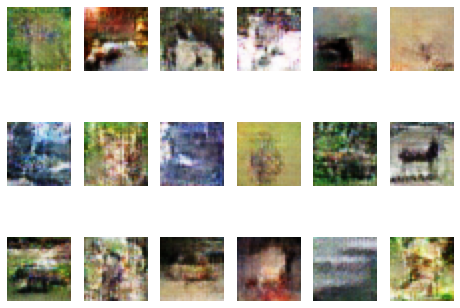

In [21]:
tf.random.set_seed(42)
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
sample_score = tf.random.normal([10000,NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(8,6), subplot=(3,6), save=False, is_flatten=False, show_fig=True)

### Defining WGAN training steps

In [22]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            # Generate fake image
            fake_image = generator([noise], training=True)
            # Mix real and fake image
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            # Get prediction
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        # Calculate the Wesserstein loss
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss

@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        # create fake image
        fake_image = generator([noise], training=True)
        # get fake image prediction
        fake_pred = discriminator([fake_image], training=True)
        # calculate loss
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss

### WGAN Training

In [23]:
current_learning_rate = LR
trace = True
n_critic_count = 0
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate, D_optimizer, G_optimizer)
    
    for step, (image) in enumerate(X_train):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        D_loss = WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            G_loss = WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0
        
        if step % 10 == 0:
            print ('.', end='')

    tf.print('\nDisc Loss:', D_loss)
    tf.print('Gen Loss:', G_loss)

    
    if epoch % 50 == 0:
        # Using a consistent sample so that the progress of the model is clearly visible.
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)
        results = calculate_scores(generator,[sample_score],MODEL_NAME,epoch)
        IS_mean = results[0]
        IS_stddev = results[1]
        FID_value = results[2]

        
        for typeof,result in zip(score_type,results):
            print(typeof,result)
            
        save_training(EPOCH_DIR,DISC_LOSS_DIR, GEN_LOSS_DIR,IS_MEAN_DIR,IS_STDDEV_DIR,FID_DIR,epoch,
                      D_loss, G_loss,IS_mean, IS_stddev,FID_value)    
        clear_folder(MODEL_NAME)

    if epoch % 55 ==0 and epoch != 0:
        clear_output(wait=True) 
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=False)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHS,
                                                        ckpt_save_path))

generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)

Saving checkpoint for epoch 1650 at checkpoints/tensorflow/WGAN_GP/ckpt-111
Time taken for epoch 1650 is 75.13900518417358 sec

Start of epoch 1651
current_learning_rate 0.000099
........................................
Disc Loss: -6.50480843
Gen Loss: 967.621582
Time taken for epoch 1651 is 14.556806325912476 sec

Start of epoch 1652
current_learning_rate 0.000099
........................................
Disc Loss: -5.46701288
Gen Loss: 967.604248
Time taken for epoch 1652 is 14.546284198760986 sec

Start of epoch 1653
current_learning_rate 0.000099
........................................
Disc Loss: -5.29153252
Gen Loss: 969.294434
Time taken for epoch 1653 is 14.571361541748047 sec

Start of epoch 1654
current_learning_rate 0.000099
........................................
Disc Loss: -6.24790812
Gen Loss: 970.542786
Time taken for epoch 1654 is 14.564459562301636 sec

Start of epoch 1655
current_learning_rate 0.000099
........................................
Disc Loss: -6.41173363
G

KeyboardInterrupt: 

I stopped training the GAN due to the values I obtained from the training. 

For the discriminator loss, the values ranged from -4.3873005 at epoch 0 to -1.8557218 at epoch 150, indicating worse performance over time. Similarly, the generator loss started off much lower at 7.7341976 and ended at 39.585037, indicating a worsening with time. 

The FID and Inception scores, however, both had results that remained constant with no major change, with the FID score having the same value at 181.86505 for all epochs and the Inception score having a mean and standard deviation of 1.0 and 0.0, respectively. Finally, the KID score had a mean of 0.70567 at epoch 0 and 0.7062 at epoch 150 and a standard deviation of 0.00315 at epoch 0 and 0.00314 at epoch 150, indicating a minimal improvement over time. 

Given that the performance of the GAN was decreasing in the discriminator and generator loss, while the other metrics showed no significant improvement, it was clear that the GAN had reached a point of diminishing returns and needed to be stopped.


### Result Analysis

![wgan](outputs/WGAN_GP/WGAN_GP.gif)

We can see that the WGAN is able to generate decently coloured images that resemble potential original images, but they lack detail. Additionally, we can see that halfway through the training process, there was hints of potential mode collapse, where the GAN was only generating a few images, and the rest were the same. That in combination with the artifacting in the images, we can see that the WGAN is not a good model for this dataset.

In [ ]:
%tensorboard --logdir logs/tensorflow/DCGAN --host localhost

## Custom WGAN-GP with SyncBatchNorm

### Hyperparameters

In [27]:
MODEL_NAME = 'WGAN_SyncBN'

DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
EPOCH_DIR = os.path.join("training_info",MODEL_NAME,"epoch")
GEN_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"gen")
DISC_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"disc")
IS_MEAN_DIR = os.path.join("training_info",MODEL_NAME,"is_mean")
IS_STDDEV_DIR = os.path.join("training_info",MODEL_NAME,"is_stddev")
FID_DIR = os.path.join("training_info",MODEL_NAME,"fid")
SINGLE_IMAGE_DIR = os.path.join("datasets",MODEL_NAME)


dir_setup()
        
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
NOISE_DIM = 128



Directory: 'outputs/WGAN_SyncBN' accessed.
Directory: 'training_info/WGAN_SyncBN/epoch' accessed.
Directory: 'training_info/WGAN_SyncBN/gen' accessed.
Directory: 'training_info/WGAN_SyncBN/disc' accessed.
Directory: 'training_info/WGAN_SyncBN/is_mean' accessed.
Directory: 'training_info/WGAN_SyncBN/is_stddev' accessed.
Directory: 'training_info/WGAN_SyncBN/fid' accessed.
Directory: 'datasets/WGAN_SyncBN' accessed.


### Declaring Generator and Discriminator

In [28]:
from tensorflow.keras.layers.experimental import SyncBatchNormalization

def CGAN_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)
    
    z = Dense(2*2*128, use_bias=False)(input_z_layer)
    z =Reshape((2, 2, 128))(z)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = SyncBatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = SyncBatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
#     x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = SyncBatchNormalization()(x)
#     x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output)
    return model

def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)
    
#     x = Conv2D(32, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
#     x = SyncBatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
#     x = SyncBatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    x = SyncBatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
#     x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = SyncBatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = SyncBatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     x = Conv2D(1024, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
#     x = SyncBatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

#     x = Conv2D(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output)
    return model

# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

generator = CGAN_generator()
discriminator = CGAN_discriminator()
print(generator.summary())
print(discriminator.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               65536     
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 128)         262144    
_________________________________________________________________
sync_batch_normalization (Sy (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         262144

### Setting up Checkpoints

In [29]:
CURRENT_EPOCH = checkpoint(generator=generator, discriminator=discriminator, G_optimizer=G_optimizer, D_optimizer=D_optimizer)
print(CURRENT_EPOCH)

Latest checkpoint of epoch 3135 restored!
Current Epoch 3135
3135


### Generate random noise

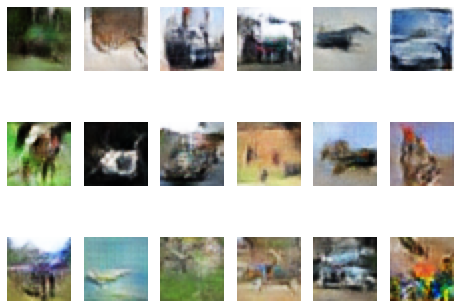

In [30]:
tf.random.set_seed(42)
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
sample_score = tf.random.normal([10000,NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(8,6), subplot=(3,6), save=False, is_flatten=False, show_fig=True)

### Defining WGAN-SyncBN training steps

In [31]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            # Generate fake image
            fake_image = generator([noise], training=True)
            # Mix real and fake image
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            # Get prediction
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        # Calculate the Wesserstein loss
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss

@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        # create fake image
        fake_image = generator([noise], training=True)
        # get fake image prediction
        fake_pred = discriminator([fake_image], training=True)
        # calculate loss
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
            
    return G_loss

The initial `with` mixes the real and fake images together by performing element-wise multiplication between the real image and epsilon, and element-wise multiplication between the fake image and 1 - epsilon, and then adding the results together. This creates a mixed image that contains elements from both the real and fake images.

The mixed image is then passed through the discriminator to get a prediction. The gradients of the prediction with respect to the mixed image are then computed using the gp_tape context, and the gradient penalty is calculated as the mean squared difference between the norm of the gradients and 1.

While the mixed image contains elements from both the real and fake images, the discriminator is not being trained to classify the mixed image as either real or fake. Instead, the mixed image is being used to compute the gradient penalty, which is used to ensure that the discriminator's decision boundary is smooth. This helps the discriminator learn to more accurately distinguish between real and fake images, which can improve the performance of the GAN overall.

For the outer `with` the real and fake images are being passed through the discriminator separately, and the discriminator is being trained to predict whether each image is real or fake based on its input.

The mixed image created by combining the real and fake images is not being used to train the discriminator. Instead, it is being used to compute the gradient penalty, which is used to ensure that the discriminator's decision boundary is smooth. This helps the discriminator learn to more accurately distinguish between real and fake images, which can improve the performance of the GAN overall.

The real and fake images are passed through the discriminator to get predictions (`fake_pred` and `real_pred`, respectively). These predictions are then used to calculate the loss for the discriminator, which is the mean of the fake predictions minus the mean of the real predictions, plus the gradient penalty. This loss is then used to update the weights of the discriminator using an optimizer.


### WGAN-SyncBN Training

In [32]:
current_learning_rate = LR
trace = True
n_critic_count = 0
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate, D_optimizer, G_optimizer)
    
    for step, (image) in enumerate(X_train):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        D_loss = WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            G_loss = WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0
        
        if step % 10 == 0:
            print ('.', end='')

    tf.print('\nDisc Loss:', D_loss)
    tf.print('Gen Loss:', G_loss)

    
    if epoch % 50 == 0:
        # Using a consistent sample so that the progress of the model is clearly visible.
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)
        results = calculate_scores(generator,[sample_score],MODEL_NAME,epoch)
        IS_mean = results[0]
        IS_stddev = results[1]
        FID_value = results[2]

        
        for typeof,result in zip(score_type,results):
            print(typeof,result)
            
        save_training(EPOCH_DIR,DISC_LOSS_DIR, GEN_LOSS_DIR,IS_MEAN_DIR,IS_STDDEV_DIR,FID_DIR,epoch,
                      D_loss, G_loss,IS_mean, IS_stddev,FID_value)    
        clear_folder(MODEL_NAME)

    if epoch % 55 ==0 and epoch != 0:
        clear_output(wait=True) 
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=False)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHS,
                                                        ckpt_save_path))

generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)

Start of epoch 3135
current_learning_rate 0.000100
retrace
.retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
.retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
.retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
.retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
retrace
.retrace
retrace
retrace
retrace
retrace
retrace


KeyboardInterrupt: 


I stopped training the GAN after 200 epochs due to the values for both the discriminator and generator losses. The discriminator loss values showed a steady decrease from the first epoch of -10.250439 to the 200th epoch of -1.8826356, indicating that the discriminator was becoming more and more accurate in distinguishing between real and generated images. However, the generator loss values showed an increase from 5.556781 in the first epoch to -6.1540966 in the 200th epoch, indicating that the generator was not improving in its ability to generate realistic images. 

The other values such as FID score, Inception mean remained unchanged throughout the training process, suggesting that there was no further progress being made on the GAN model. Therefore, I chose to stop training the GAN after 200 epochs.


### Result Analysis

![wgan_syncbn](outputs/WGAN_SyncBN/WGAN_SyncBN.gif)

After analysis, we see that the performance of the model leaves a lot to be desired. However, it is also important to note that the images generated do not have very black blacks and bright whites. This means that the model is not completely useless, and can be used to generate images that are not completely unrealistic. This is due to the use of Wasserstein loss, which is a more stable loss function than the traditional GAN loss function. This results in the model being able to generate images that are not completely unrealistic, but are also not completely realistic.

## SNGAN

Spectral Normalisation GAN with Hinge Loss and Adaptive Augmentation 

### Hyperparameters

In [ ]:
MODEL_NAME = 'SNGAN'

DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
EPOCH_DIR = os.path.join("training_info",MODEL_NAME,"epoch")
GEN_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"gen")
DISC_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"disc")
IS_MEAN_DIR = os.path.join("training_info",MODEL_NAME,"is_mean")
IS_STDDEV_DIR = os.path.join("training_info",MODEL_NAME,"is_stddev")
FID_DIR = os.path.join("training_info",MODEL_NAME,"fid")
SINGLE_IMAGE_DIR = os.path.join("datasets",MODEL_NAME)


dir_setup()

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
NOISE_DIM = 128

Directory: 'outputs/SNGAN' accessed.
Directory: 'training_info/SNGAN/epoch' accessed.
Directory: 'training_info/SNGAN/gen' accessed.
Directory: 'training_info/SNGAN/disc' accessed.
Directory: 'training_info/SNGAN/is_mean' accessed.
Directory: 'training_info/SNGAN/is_stddev' accessed.
Directory: 'training_info/SNGAN/fid' accessed.
Directory: 'datasets/SNGAN' accessed.


### Generator and Discriminator

In [12]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

spectral_norm = True

def SNGAN_OLS_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output,name='generator')
    return model


def SNGAN_OLS_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)

    x= spectral_norm_wrapper(
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
        spectral_norm=spectral_norm,
        )(input_x_layer)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output, name='discriminator')
    return model

# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

generator = SNGAN_OLS_generator()
discriminator = SNGAN_OLS_discriminator()
print(generator.summary())
print(discriminator.summary())

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1048576   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         20

### Setting up Checkpoints

In [13]:
CURRENT_EPOCH = checkpoint(generator=generator, discriminator=discriminator, G_optimizer=G_optimizer, D_optimizer=D_optimizer)
print(CURRENT_EPOCH)

Latest checkpoint of epoch 780 restored!
Current Epoch 780
780


### Generate random noise

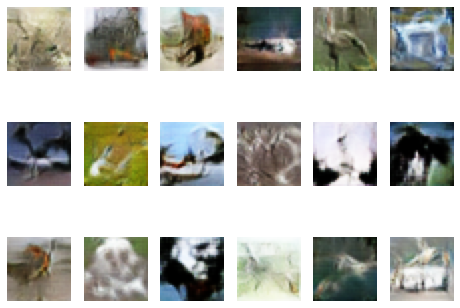

In [14]:
tf.random.set_seed(42)
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
sample_score = tf.random.normal([10000,NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(8,6), subplot=(3,6), save=False, is_flatten=False, show_fig=True)

### Defining SNGAN training steps

In [15]:
def relu(x):
    return tf.nn.relu(x)

@tf.function
def SNGAN_GP_train_d_step(real_image, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            # Generate fake image
            fake_image = generator([noise], training=True)

            # Mix real and fake image
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            # Get prediction
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        # Calculate the Hinge loss
         # Calculate the Hinge loss
        h = tf.keras.losses.Hinge()
        real_label= tf.ones((batch_size,1))
        real_loss = h(real_pred,real_label)
        h = tf.keras.losses.Hinge()
        fake_label=tf.zeros((batch_size,1))
        fake_loss= h(fake_pred,fake_label)
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty

        
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    # Update the probability of image augmentation
    augmenter.update(real_pred)
    
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss
@tf.function
def SNGAN_GP_train_g_step(real_image, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        # create fake image
        fake_image = generator([noise], training=True)
        
        
        # get fake image prediction
        fake_pred = discriminator([fake_image], training=True)
        # calculate loss
        G_loss = -tf.reduce_mean(fake_pred)
    
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss

### SNGAN Training

Time taken for epoch 1100 is 83.68162655830383 sec

Start of epoch 1101
current_learning_rate 0.000099
........................................
Disc Loss: -0.370453894
Gen Loss: 0.390725493
Time taken for epoch 1101 is 15.059033155441284 sec

Start of epoch 1102
current_learning_rate 0.000099
........................................
Disc Loss: -0.476503789
Gen Loss: 2.13935566
Time taken for epoch 1102 is 15.033083200454712 sec

Start of epoch 1103
current_learning_rate 0.000099
........................................
Disc Loss: -0.307715923
Gen Loss: 5.74339104
Time taken for epoch 1103 is 15.081960439682007 sec

Start of epoch 1104
current_learning_rate 0.000099
........................................
Disc Loss: -0.124531075
Gen Loss: -7.05360031
Time taken for epoch 1104 is 16.755655527114868 sec

Start of epoch 1105
current_learning_rate 0.000099
........................................
Disc Loss: -0.0404994041
Gen Loss: 8.29579353
Time taken for epoch 1105 is 15.4926278591156 se

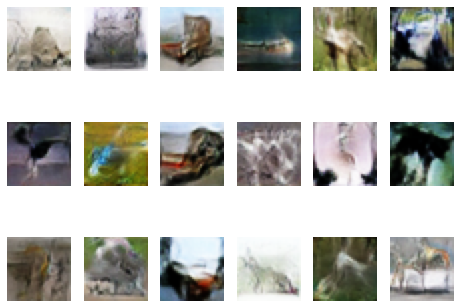


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN


FID SNGAN: 100%|██████████| 313/313 [00:18<00:00, 16.70it/s]


IS Mean: 6.20742
IS Std.Dev: 0.23745
FID: 64.28229
Saving checkpoint for epoch 1110 at checkpoints/tensorflow/SNGAN/ckpt-75
Time taken for epoch 1110 is 83.31425976753235 sec

Start of epoch 1111
current_learning_rate 0.000099
........................................
Disc Loss: -0.237119168
Gen Loss: 3.34819889
Time taken for epoch 1111 is 15.295138120651245 sec

Start of epoch 1112
current_learning_rate 0.000099
........................................
Disc Loss: -0.316343337
Gen Loss: -2.12171
Time taken for epoch 1112 is 15.39374828338623 sec

Start of epoch 1113
current_learning_rate 0.000099
........................................
Disc Loss: -0.720652699
Gen Loss: 0.120667547
Time taken for epoch 1113 is 14.842421054840088 sec

Start of epoch 1114
current_learning_rate 0.000099
........................................
Disc Loss: -0.575125515
Gen Loss: 4.47524929
Time taken for epoch 1114 is 15.324895143508911 sec

Start of epoch 1115
current_learning_rate 0.000099
...............

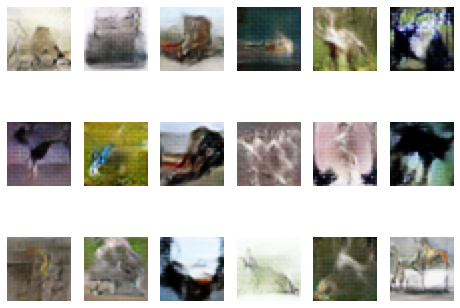


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN


FID SNGAN: 100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


IS Mean: 6.09428
IS Std.Dev: 0.13994
FID: 80.96391
Time taken for epoch 1120 is 84.6342282295227 sec

Start of epoch 1121
current_learning_rate 0.000099
........................................
Disc Loss: -0.185017645
Gen Loss: -0.344713509
Time taken for epoch 1121 is 15.281900644302368 sec

Start of epoch 1122
current_learning_rate 0.000099
........................................
Disc Loss: -0.329453707
Gen Loss: -1.53868473
Time taken for epoch 1122 is 15.471643686294556 sec

Start of epoch 1123
current_learning_rate 0.000099
........................................
Disc Loss: -0.285715699
Gen Loss: -1.51735
Time taken for epoch 1123 is 15.216137647628784 sec

Start of epoch 1124
current_learning_rate 0.000099
........................................
Disc Loss: -0.55148232
Gen Loss: -1.9886601
Time taken for epoch 1124 is 14.914010047912598 sec

Start of epoch 1125
current_learning_rate 0.000099
........................................
Disc Loss: -0.296488017
Gen Loss: -1.8106482
S

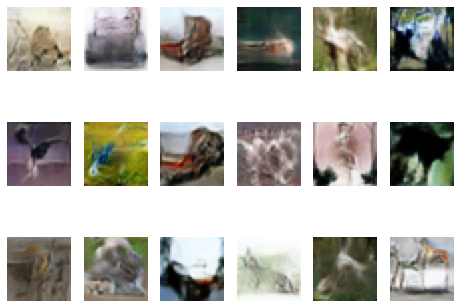


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN


FID SNGAN: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s]


IS Mean: 6.27785
IS Std.Dev: 0.1702
FID: 62.63957
Time taken for epoch 1130 is 84.14113855361938 sec

Start of epoch 1131
current_learning_rate 0.000099
........................................
Disc Loss: -0.21441099
Gen Loss: 1.80272877
Time taken for epoch 1131 is 15.443440914154053 sec

Start of epoch 1132
current_learning_rate 0.000099
........................................
Disc Loss: -0.195389435
Gen Loss: 4.71315861
Time taken for epoch 1132 is 15.257593870162964 sec

Start of epoch 1133
current_learning_rate 0.000099
........................................
Disc Loss: -0.862926602
Gen Loss: 5.04001427
Time taken for epoch 1133 is 15.222831726074219 sec

Start of epoch 1134
current_learning_rate 0.000099
........................................
Disc Loss: -0.145891771
Gen Loss: -3.18793178
Time taken for epoch 1134 is 14.924038171768188 sec

Start of epoch 1135
current_learning_rate 0.000099
........................................
Disc Loss: -0.217048064
Gen Loss: 5.45555305
T

In [ ]:
current_learning_rate = LR
trace = True
n_critic_count = 0
image_size = 32



augmenter = AdaptiveAugmenter(
    target_accuracy=0.9,
    integration_steps=10,
    max_probability=0.5,
    input_shape=(image_size, image_size, 3)
)


for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate, D_optimizer, G_optimizer)
    
    for step, (image) in enumerate(X_train):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        augmented_images = augmenter(image, training=True)
        D_loss = SNGAN_GP_train_d_step(real_image= augmented_images,batch_size=tf.constant(current_batch_size, dtype=tf.int64), 
                                                step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            G_loss = SNGAN_GP_train_g_step(augmented_images,batch_size= tf.constant(current_batch_size, dtype=tf.int64), 
                                           step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0
        
        if step % 10 == 0:
            print ('.', end='')

    tf.print('\nDisc Loss:', D_loss)
    tf.print('Gen Loss:', G_loss)

    
    if epoch % 10 == 0:
        # Using a consistent sample so that the progress of the model is clearly visible.
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)
        results = calculate_scores(generator,[sample_score],MODEL_NAME,epoch)
        IS_mean = results[0]
        IS_stddev = results[1]
        FID_value = results[2]

        
        for typeof,result in zip(score_type,results):
            print(typeof,result)
            
        save_training(EPOCH_DIR,DISC_LOSS_DIR, GEN_LOSS_DIR,IS_MEAN_DIR,IS_STDDEV_DIR,FID_DIR,epoch,
                      D_loss, G_loss,IS_mean, IS_stddev,FID_value)    
        clear_folder(MODEL_NAME)

    if epoch % 55 ==0 and epoch != 0:
        clear_output(wait=True) 
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=False)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHS,
                                                        ckpt_save_path))

generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)

### Results Analysis

![SNGAN Results](outputs/SNGAN/SNGAN.gif)

## SNGAN_OLS

Spectral Normalisation GAN with Hinge Loss and Adaptive Augmentation + One-Sided Label Smoothing

### Hyperparameters

In [11]:
MODEL_NAME = 'SNGAN_OLS'

DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
EPOCH_DIR = os.path.join("training_info",MODEL_NAME,"epoch")
GEN_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"gen")
DISC_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"disc")
IS_MEAN_DIR = os.path.join("training_info",MODEL_NAME,"is_mean")
IS_STDDEV_DIR = os.path.join("training_info",MODEL_NAME,"is_stddev")
FID_DIR = os.path.join("training_info",MODEL_NAME,"fid")
SINGLE_IMAGE_DIR = os.path.join("datasets",MODEL_NAME)


dir_setup()

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
NOISE_DIM = 128

Directory: 'outputs/SNGAN_OLS' accessed.
Directory: 'training_info/SNGAN_OLS/epoch' accessed.
Directory: 'training_info/SNGAN_OLS/gen' accessed.
Directory: 'training_info/SNGAN_OLS/disc' accessed.
Directory: 'training_info/SNGAN_OLS/is_mean' accessed.
Directory: 'training_info/SNGAN_OLS/is_stddev' accessed.
Directory: 'training_info/SNGAN_OLS/fid' accessed.
Directory: 'datasets/SNGAN_OLS' accessed.


### Generator and Discriminator

In [12]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

spectral_norm = True

def SNGAN_OLS_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output,name='generator')
    return model


def SNGAN_OLS_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)

    x= spectral_norm_wrapper(
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
        spectral_norm=spectral_norm,
        )(input_x_layer)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output, name='discriminator')
    return model

# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

generator = SNGAN_OLS_generator()
discriminator = SNGAN_OLS_discriminator()
print(generator.summary())
print(discriminator.summary())

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1048576   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         20

### Setting up Checkpoints

In [13]:
CURRENT_EPOCH = checkpoint(generator=generator, discriminator=discriminator, G_optimizer=G_optimizer, D_optimizer=D_optimizer)
print(CURRENT_EPOCH)

Latest checkpoint of epoch 660 restored!
Current Epoch 660
660


### Generate random noise

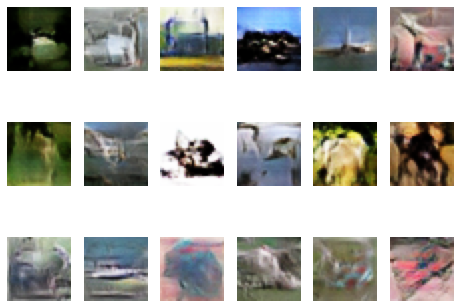

In [14]:
tf.random.set_seed(42)
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
sample_score = tf.random.normal([10000,NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(8,6), subplot=(3,6), save=False, is_flatten=False, show_fig=True)

### Defining SNGAN_OLS training steps

In [15]:
def relu(x):
    return tf.nn.relu(x)

@tf.function
def SNGAN_GP_train_d_step(real_image, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            # Generate fake image
            fake_image = generator([noise], training=True)

            # Mix real and fake image
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            # Get prediction
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        # Calculate the Hinge loss
         # Calculate the Hinge loss
        h = tf.keras.losses.Hinge()
        real_label= OLS(real_image.shape[0])
        real_loss = h(real_pred,real_label)
        h = tf.keras.losses.Hinge()
        fake_label=tf.zeros((batch_size,1))
        fake_loss= h(fake_pred,fake_label)
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty

        
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    # Update the probability of image augmentation
    augmenter.update(real_pred)
    
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss
@tf.function
def SNGAN_GP_train_g_step(real_image, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        # create fake image
        fake_image = generator([noise], training=True)
        
        
        # get fake image prediction
        fake_pred = discriminator([fake_image], training=True)
        # calculate loss
        G_loss = -tf.reduce_mean(fake_pred)
    
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss

### SNGAN_OLS Training

Saving checkpoint for epoch 1155 at checkpoints/tensorflow/SNGAN_OLS/ckpt-78
Time taken for epoch 1155 is 15.395497798919678 sec

Start of epoch 1156
current_learning_rate 0.000098
........................................
Disc Loss: -0.102820158
Gen Loss: 11.8252897
Time taken for epoch 1156 is 14.668261289596558 sec

Start of epoch 1157
current_learning_rate 0.000098
........................................
Disc Loss: -0.293364614
Gen Loss: -5.98918152
Time taken for epoch 1157 is 14.607267141342163 sec

Start of epoch 1158
current_learning_rate 0.000098
........................................
Disc Loss: -0.376604438
Gen Loss: -7.74803734
Time taken for epoch 1158 is 14.582476615905762 sec

Start of epoch 1159
current_learning_rate 0.000098
........................................
Disc Loss: -0.531011
Gen Loss: 1.1177088
Time taken for epoch 1159 is 14.717741966247559 sec

Start of epoch 1160
current_learning_rate 0.000098
........................................
Disc Loss: -0.277721

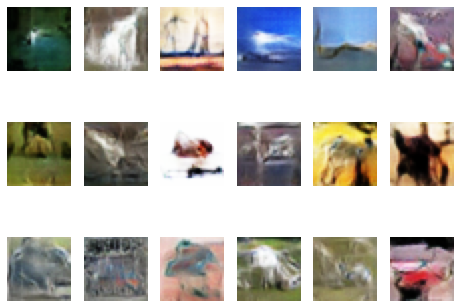


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN_OLS


FID SNGAN_OLS: 100%|██████████| 313/313 [00:18<00:00, 16.97it/s]


IS Mean: 6.05686
IS Std.Dev: 0.11766
FID: 63.65618
Time taken for epoch 1160 is 79.41623950004578 sec

Start of epoch 1161
current_learning_rate 0.000098
........................................
Disc Loss: -0.447911203
Gen Loss: -3.28865
Time taken for epoch 1161 is 14.243908882141113 sec

Start of epoch 1162
current_learning_rate 0.000098
........................................
Disc Loss: -0.149432912
Gen Loss: 5.02980947
Time taken for epoch 1162 is 14.255445718765259 sec

Start of epoch 1163
current_learning_rate 0.000098
........................................
Disc Loss: -0.53959465
Gen Loss: 4.27791548
Time taken for epoch 1163 is 14.20920443534851 sec

Start of epoch 1164
current_learning_rate 0.000098
........................................
Disc Loss: -0.0683513954
Gen Loss: 0.971177876
Time taken for epoch 1164 is 14.215555429458618 sec

Start of epoch 1165
current_learning_rate 0.000098
........................................
Disc Loss: -0.434665978
Gen Loss: 4.47026443
Ti

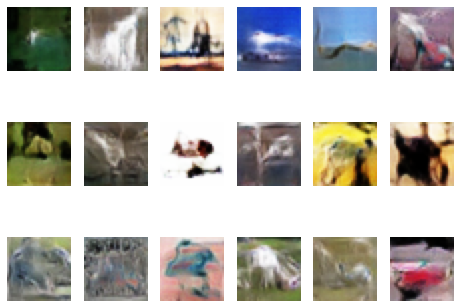


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN_OLS


FID SNGAN_OLS: 100%|██████████| 313/313 [00:19<00:00, 16.37it/s]


IS Mean: 6.20726
IS Std.Dev: 0.13819
FID: 63.3337
Saving checkpoint for epoch 1170 at checkpoints/tensorflow/SNGAN_OLS/ckpt-79
Time taken for epoch 1170 is 80.0327730178833 sec

Start of epoch 1171
current_learning_rate 0.000098
........................................
Disc Loss: -0.420356393
Gen Loss: 4.5161047
Time taken for epoch 1171 is 14.813001155853271 sec

Start of epoch 1172
current_learning_rate 0.000098
........................................
Disc Loss: -0.612795234
Gen Loss: 7.27945328
Time taken for epoch 1172 is 14.78173279762268 sec

Start of epoch 1173
current_learning_rate 0.000098
........................................
Disc Loss: -0.241682738
Gen Loss: 0.934894502
Time taken for epoch 1173 is 14.749699831008911 sec

Start of epoch 1174
current_learning_rate 0.000098
........................................
Disc Loss: -0.739624
Gen Loss: -1.19639206
Time taken for epoch 1174 is 14.747960805892944 sec

Start of epoch 1175
current_learning_rate 0.000098
..............

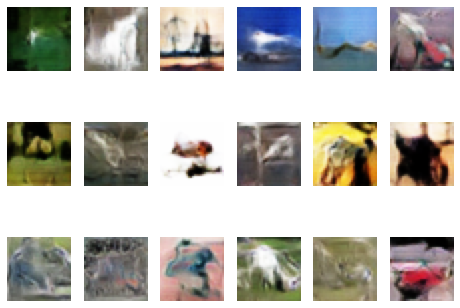


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN_OLS


FID SNGAN_OLS: 100%|██████████| 313/313 [00:18<00:00, 16.92it/s]


IS Mean: 6.17254
IS Std.Dev: 0.11691
FID: 63.11884
Time taken for epoch 1180 is 82.29673171043396 sec

Start of epoch 1181
current_learning_rate 0.000098
........................................
Disc Loss: 0.141561836
Gen Loss: -5.27388859
Time taken for epoch 1181 is 14.382155418395996 sec

Start of epoch 1182
current_learning_rate 0.000098
........................................
Disc Loss: -0.593952239
Gen Loss: -1.2220403
Time taken for epoch 1182 is 14.205698728561401 sec

Start of epoch 1183
current_learning_rate 0.000098
........................................
Disc Loss: -0.337145597
Gen Loss: 2.571697
Time taken for epoch 1183 is 14.207879304885864 sec

Start of epoch 1184
current_learning_rate 0.000098
........................................
Disc Loss: 0.056150347
Gen Loss: -1.62473798
Time taken for epoch 1184 is 14.223577499389648 sec

Start of epoch 1185
current_learning_rate 0.000098
........................................
Disc Loss: -0.355966032
Gen Loss: 1.35040557
Sa

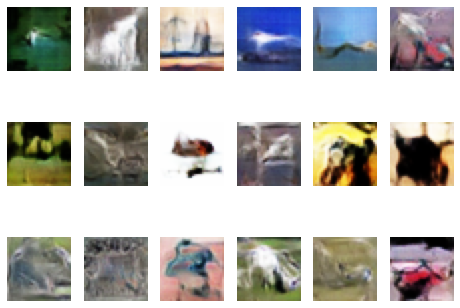


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN_OLS


FID SNGAN_OLS: 100%|██████████| 313/313 [00:18<00:00, 16.76it/s]


IS Mean: 6.21018
IS Std.Dev: 0.13203
FID: 65.07678
Time taken for epoch 1190 is 78.39581441879272 sec

Start of epoch 1191
current_learning_rate 0.000098
........................................
Disc Loss: -0.480927587
Gen Loss: 2.35064292
Time taken for epoch 1191 is 14.714277505874634 sec

Start of epoch 1192
current_learning_rate 0.000098
........................................
Disc Loss: -0.918039203
Gen Loss: 1.91948259
Time taken for epoch 1192 is 14.278530359268188 sec

Start of epoch 1193
current_learning_rate 0.000098
........................................
Disc Loss: -0.176851079
Gen Loss: 4.56709862
Time taken for epoch 1193 is 14.347986221313477 sec

Start of epoch 1194
current_learning_rate 0.000098
........................................
Disc Loss: -0.274516225
Gen Loss: 6.76153326
Time taken for epoch 1194 is 14.343244791030884 sec

Start of epoch 1195
current_learning_rate 0.000098
........................................
Disc Loss: -0.176144958
Gen Loss: -0.356398
T

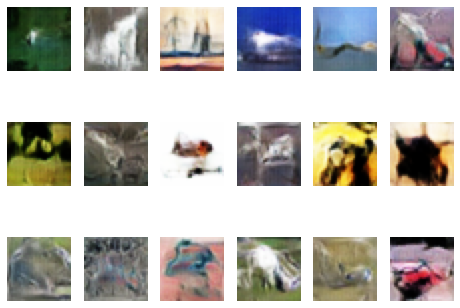


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN_OLS


FID SNGAN_OLS: 100%|██████████| 313/313 [00:21<00:00, 14.70it/s]


IS Mean: 6.26404
IS Std.Dev: 0.15248
FID: 62.57674
Saving checkpoint for epoch 1200 at checkpoints/tensorflow/SNGAN_OLS/ckpt-81
Time taken for epoch 1200 is 85.2909688949585 sec

Start of epoch 1201
current_learning_rate 0.000098
........................................
Disc Loss: 0.115756989
Gen Loss: 2.61176276
Time taken for epoch 1201 is 14.578554153442383 sec

Start of epoch 1202
current_learning_rate 0.000098
........................................
Disc Loss: 0.0619928
Gen Loss: 6.23559093
Time taken for epoch 1202 is 14.829161643981934 sec

Start of epoch 1203
current_learning_rate 0.000098
........................................
Disc Loss: -0.103613779
Gen Loss: 3.86600685
Time taken for epoch 1203 is 14.377990961074829 sec

Start of epoch 1204
current_learning_rate 0.000098
........................................
Disc Loss: -0.735241175
Gen Loss: 6.25315
Time taken for epoch 1204 is 14.903738975524902 sec

Start of epoch 1205
current_learning_rate 0.000098
.................

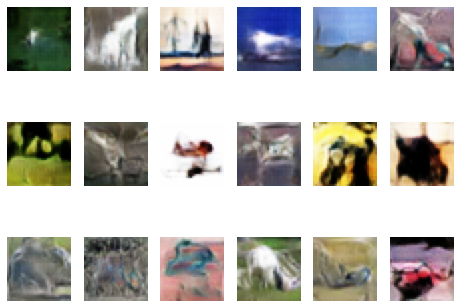


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID SNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/SNGAN_OLS


FID SNGAN_OLS:  39%|███▉      | 123/313 [00:08<00:13, 13.87it/s]


RuntimeError: DataLoader worker (pid 75377) is killed by signal: Killed. 

In [16]:
current_learning_rate = LR
trace = True
n_critic_count = 0
image_size = 32



augmenter = AdaptiveAugmenter(
    target_accuracy=0.9,
    integration_steps=10,
    max_probability=0.5,
    input_shape=(image_size, image_size, 3)
)


for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate, D_optimizer, G_optimizer)
    
    for step, (image) in enumerate(X_train):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        augmented_images = augmenter(image, training=True)
        D_loss = SNGAN_GP_train_d_step(real_image= augmented_images,batch_size=tf.constant(current_batch_size, dtype=tf.int64), 
                                                step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            G_loss = SNGAN_GP_train_g_step(augmented_images,batch_size= tf.constant(current_batch_size, dtype=tf.int64), 
                                           step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0
        
        if step % 10 == 0:
            print ('.', end='')

    tf.print('\nDisc Loss:', D_loss)
    tf.print('Gen Loss:', G_loss)

    
    if epoch % 10 == 0:
        # Using a consistent sample so that the progress of the model is clearly visible.
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)
        results = calculate_scores(generator,[sample_score],MODEL_NAME,epoch)
        IS_mean = results[0]
        IS_stddev = results[1]
        FID_value = results[2]

        
        for typeof,result in zip(score_type,results):
            print(typeof,result)
            
        save_training(EPOCH_DIR,DISC_LOSS_DIR, GEN_LOSS_DIR,IS_MEAN_DIR,IS_STDDEV_DIR,FID_DIR,epoch,
                      D_loss, G_loss,IS_mean, IS_stddev,FID_value)    
        clear_folder(MODEL_NAME)

    if epoch % 55 ==0 and epoch != 0:
        clear_output(wait=True) 
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=False)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHS,
                                                        ckpt_save_path))

generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)

### Results Analysis

![SNGAN_OLS](outputs/SNGAN_OLS/SNGAN_OLS.gif)

We can see that the images generated are not very realistic, and the model is not able to generate images that are similar to the original images. This is because the model is not able to learn the underlying distribution of the images, and is not able to generate images that are similar to the original images. Additionally, since there is no conditionality in the model, the model is not able to generate images that are similar to the original images in terms of the class labels.


## Conditional SNGAN (Hidden Concat) with Hinge Loss + Label Smoothing (CSNGAN_OLS) & Image Augmentation

This is an implementation of the above CSNGAN_OLS with image labels from the original dataset. We apply the same hyperparameters as the above CSNGAN_OLS. We apply 2 forms of regularisation, using one-sided label smoothing and gradient penalty.

I applied Class Embedding to include the labels. The labels applied are not in one-hot-encoding as the embedding layer only takes in non one-hot encoded labels.

For the discriminator labels, they are imported as `disc_labels` in the shape of (`batch`,1), then embedded and reshaped to form a (`batch`,32,32,1), then concatenated to the (`batch`,32,32,3) image along the last axis to form a (`batch`, 32,32,4) input to the discriminator.

For the generator labels, it is a bit confusing as the `latent dimension` and `batch size` are the same, hence I will use the variable names instead of the actual numbers. 

The generator labels are imported as `labels` in the shape of (`batch`,1). They are then embedded and reshaped into (`batch size`, `latent dimension`). I am essentially mapping each label (an integer between 0 and 9) to a fixed-size vector of real numbers. This vector would then be stretched out to the batch size, so that each example in the batch has a corresponding embedding vector.

After that, I concatenate the initial latent dimension input with the embedded labels, forming an input of (`batch size`, 2*`latent dimension`). This is why the input to the generator is `256`, as `128 + 128 = 256`




In [12]:
from tensorflow.keras.layers import Dropout
MODEL_NAME = 'CSNGAN_OLS'
DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
EPOCH_DIR = os.path.join("training_info",MODEL_NAME,"epoch")
GEN_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"gen")
DISC_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"disc")
IS_MEAN_DIR = os.path.join("training_info",MODEL_NAME,"is_mean")
IS_STDDEV_DIR = os.path.join("training_info",MODEL_NAME,"is_stddev")
FID_DIR = os.path.join("training_info",MODEL_NAME,"fid")
SINGLE_IMAGE_DIR = os.path.join("datasets",MODEL_NAME)


dir_setup()

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
NOISE_DIM = 128
loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def relu(x):
    return tf.nn.relu(x)


Directory: 'outputs/CSNGAN_OLS' accessed.
Directory: 'training_info/CSNGAN_OLS/epoch' accessed.
Directory: 'training_info/CSNGAN_OLS/gen' accessed.
Directory: 'training_info/CSNGAN_OLS/disc' accessed.
Directory: 'training_info/CSNGAN_OLS/is_mean' accessed.
Directory: 'training_info/CSNGAN_OLS/is_stddev' accessed.
Directory: 'training_info/CSNGAN_OLS/fid' accessed.
Directory: 'datasets/CSNGAN_OLS' accessed.


In [14]:
generator_in_channels = NOISE_DIM + num_classes
discriminator_in_channels = 3 + num_classes
print(generator_in_channels, discriminator_in_channels)




138 13


In [15]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

spectral_norm = True

def CSNGAN_OLS_generator(input_z_shape=NOISE_DIM*2):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output,name='generator')
    return model


def CSNGAN_OLS_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 4)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)

    x= spectral_norm_wrapper(
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
        spectral_norm=spectral_norm,
        )(input_x_layer)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = spectral_norm_wrapper(Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                              spectral_norm=spectral_norm)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output, name='discriminator')
    return model

# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.3,beta_2=0.9)
G_optimizer = Adam(learning_rate=LR, beta_1=0.3,beta_2=0.9)

generator = CSNGAN_OLS_generator()
discriminator = CSNGAN_OLS_discriminator()
print(generator.summary())
print(discriminator.summary())

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              2097152   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         20

In [16]:
CURRENT_EPOCH = checkpoint(generator=generator, discriminator=discriminator, G_optimizer=G_optimizer, D_optimizer=D_optimizer)
print(CURRENT_EPOCH)

Latest checkpoint of epoch 420 restored!
Current Epoch 420
420


### Generate random noise

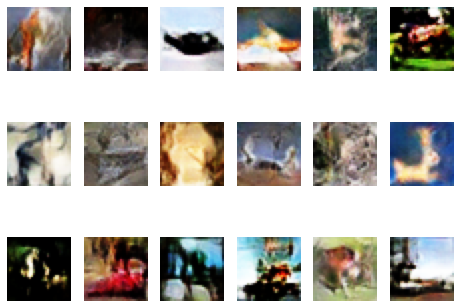

In [17]:
tf.random.set_seed(42)
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM*2])
sample_score = tf.random.normal([10000,NOISE_DIM*2])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(8,6), subplot=(3,6), save=False, is_flatten=False, show_fig=True)

### Defining CSNGAN_OLS training steps

In [18]:
def relu(x):
    return tf.nn.relu(x)

@tf.function
def SNGAN_GP_train_d_step(real_image,fake_disc,disc_labels, labels, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    noise = tf.concat([noise, labels], axis=1)
    
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            # Generate fake image
            fake_image = generator([noise], training=True)
            fake_image_and_labels = tf.concat([fake_image,fake_disc],axis=-1)
            real_image_and_labels = tf.concat([real_image, disc_labels], -1)
            
            # Mix real and fake image
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image_and_labels, tf.float32) + ((1 - epsilon) * fake_image_and_labels)
            # Get prediction
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image_and_labels], training=True)
    
        real_pred = discriminator([real_image_and_labels], training=True)
        
        # Calculate the Hinge loss
        h = tf.keras.losses.Hinge()
#         print(real_image.shape)
        real_label= OLS(real_image.shape[0])
        real_loss = h(real_pred,real_label)
#         real_loss = tf.reduce_mean(relu(1.0 - real_pred))
        h = tf.keras.losses.Hinge()
        fake_label=tf.zeros((batch_size,1))
        fake_loss= h(fake_pred,fake_label)
#         fake_loss = tf.reduce_mean(relu(1.0 + fake_pred))

        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty

        
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    # Update the probability of image augmentation
    augmenter.update(real_pred)
    
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss

@tf.function
def SNGAN_GP_train_g_step(real_image,fake_disc,disc_labels, labels, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    noise = tf.concat([noise, labels], axis=1)
    
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        # create fake image
        fake_image = generator([noise], training=True)
        fake_image_and_labels = tf.concat([fake_image,fake_disc],axis=-1)
        
    
        # get fake image prediction
        fake_pred = discriminator([fake_image_and_labels], training=True)
        # calculate loss
        G_loss = -tf.reduce_mean(fake_pred)
    
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss

### CSNGAN_OLS Training

Time taken for epoch 605 is 16.74834966659546 sec

Start of epoch 606
current_learning_rate 0.000099
........................................
Disc Loss: -0.44696331
Gen Loss: -1.58037055
Time taken for epoch 606 is 16.66267418861389 sec

Start of epoch 607
current_learning_rate 0.000099
........................................
Disc Loss: -0.429030687
Gen Loss: 3.95817518
Time taken for epoch 607 is 16.643085956573486 sec

Start of epoch 608
current_learning_rate 0.000099
........................................
Disc Loss: -0.414747179
Gen Loss: 3.33256626
Time taken for epoch 608 is 16.62743091583252 sec

Start of epoch 609
current_learning_rate 0.000099
........................................
Disc Loss: -0.746702909
Gen Loss: 0.894076526
Time taken for epoch 609 is 16.642735481262207 sec

Start of epoch 610
current_learning_rate 0.000099
........................................
Disc Loss: -0.306767851
Gen Loss: -2.37371683


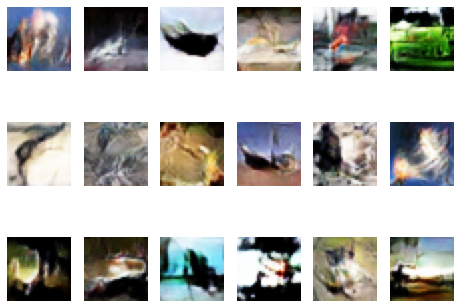


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID CSNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/CSNGAN_OLS


FID CSNGAN_OLS: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s]


IS Mean: 6.10696
IS Std.Dev: 0.08627
FID: 72.98306
Time taken for epoch 610 is 79.4727292060852 sec

Start of epoch 611
current_learning_rate 0.000099
........................................
Disc Loss: -0.489770353
Gen Loss: 1.12021613
Time taken for epoch 611 is 16.51109290122986 sec

Start of epoch 612
current_learning_rate 0.000099
........................................
Disc Loss: -0.598783731
Gen Loss: 4.92583609
Time taken for epoch 612 is 16.612797260284424 sec

Start of epoch 613
current_learning_rate 0.000099
........................................
Disc Loss: -0.817648649
Gen Loss: 8.90747356
Time taken for epoch 613 is 16.59635853767395 sec

Start of epoch 614
current_learning_rate 0.000099
........................................
Disc Loss: -0.584492862
Gen Loss: -1.5622592
Time taken for epoch 614 is 16.582597255706787 sec

Start of epoch 615
current_learning_rate 0.000099
........................................
Disc Loss: -0.1054959
Gen Loss: 1.36301231
Saving checkpoi

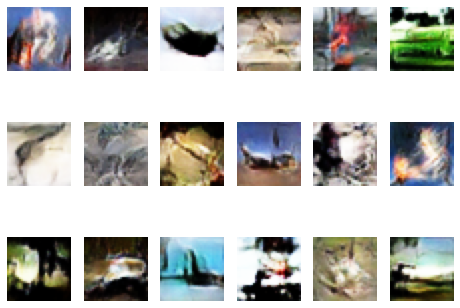


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID CSNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/CSNGAN_OLS


FID CSNGAN_OLS: 100%|██████████| 313/313 [00:18<00:00, 17.14it/s]


IS Mean: 6.09252
IS Std.Dev: 0.15982
FID: 73.89335
Time taken for epoch 620 is 79.48396944999695 sec

Start of epoch 621
current_learning_rate 0.000099
........................................
Disc Loss: -0.674095333
Gen Loss: -1.88057876
Time taken for epoch 621 is 16.65822410583496 sec

Start of epoch 622
current_learning_rate 0.000099
........................................
Disc Loss: -0.702976108
Gen Loss: 2.55355215
Time taken for epoch 622 is 16.46975588798523 sec

Start of epoch 623
current_learning_rate 0.000099
........................................
Disc Loss: -1.03414595
Gen Loss: 1.2136271
Time taken for epoch 623 is 16.55767560005188 sec

Start of epoch 624
current_learning_rate 0.000099
........................................
Disc Loss: -0.725633204
Gen Loss: 4.39907122
Time taken for epoch 624 is 16.59343719482422 sec

Start of epoch 625
current_learning_rate 0.000099
........................................
Disc Loss: 0.0584363081
Gen Loss: -5.79425764
Time taken for

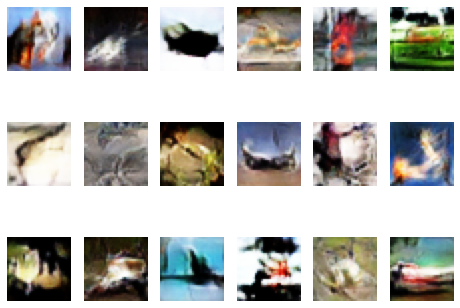


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID CSNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/CSNGAN_OLS


FID CSNGAN_OLS: 100%|██████████| 313/313 [00:18<00:00, 17.20it/s]


IS Mean: 6.17873
IS Std.Dev: 0.11588
FID: 73.35005
Saving checkpoint for epoch 630 at checkpoints/tensorflow/CSNGAN_OLS/ckpt-43
Time taken for epoch 630 is 80.18967008590698 sec

Start of epoch 631
current_learning_rate 0.000099
........................................
Disc Loss: -0.484814197
Gen Loss: 4.90973377
Time taken for epoch 631 is 16.640140771865845 sec

Start of epoch 632
current_learning_rate 0.000099
........................................
Disc Loss: -0.798013806
Gen Loss: 6.14671612
Time taken for epoch 632 is 16.6093807220459 sec

Start of epoch 633
current_learning_rate 0.000099
........................................
Disc Loss: -0.716307163
Gen Loss: 6.93176365
Time taken for epoch 633 is 16.67124605178833 sec

Start of epoch 634
current_learning_rate 0.000099
........................................
Disc Loss: -0.789822042
Gen Loss: 6.30602503
Time taken for epoch 634 is 16.542806386947632 sec

Start of epoch 635
current_learning_rate 0.000099
......................

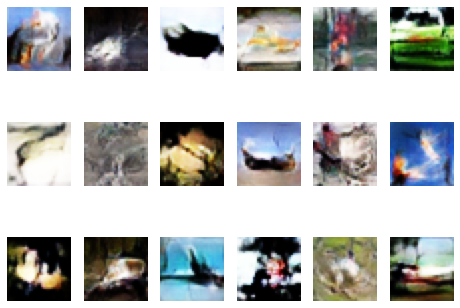


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID CSNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/CSNGAN_OLS


FID CSNGAN_OLS: 100%|██████████| 313/313 [00:18<00:00, 17.16it/s]


IS Mean: 6.00744
IS Std.Dev: 0.16709
FID: 73.17892
Time taken for epoch 640 is 80.4233067035675 sec

Start of epoch 641
current_learning_rate 0.000099
........................................
Disc Loss: 0.0606184378
Gen Loss: -9.41181374
Time taken for epoch 641 is 16.640698194503784 sec

Start of epoch 642
current_learning_rate 0.000099
........................................
Disc Loss: -0.664820373
Gen Loss: 6.49508142
Time taken for epoch 642 is 16.541763305664062 sec

Start of epoch 643
current_learning_rate 0.000099
........................................
Disc Loss: -0.836231411
Gen Loss: 2.3630414
Time taken for epoch 643 is 16.482982873916626 sec

Start of epoch 644
current_learning_rate 0.000099
........................................
Disc Loss: -0.90740782
Gen Loss: -1.62716985
Time taken for epoch 644 is 16.589781999588013 sec

Start of epoch 645
current_learning_rate 0.000099
........................................
Disc Loss: -0.225215286
Gen Loss: 0.000570505857
Saving 

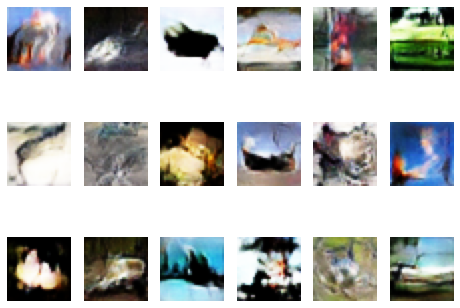


FID test:   0%|          | 0/313 [00:00<?, ?it/s]

Loading pretrained model Inception3 from /home/p2112646/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
Found 10000 images in the folder datasets/test


FID CSNGAN_OLS:   0%|          | 0/313 [00:00<?, ?it/s]

Found 10000 images in the folder datasets/CSNGAN_OLS


FID CSNGAN_OLS: 100%|██████████| 313/313 [00:18<00:00, 17.22it/s]


IS Mean: 6.0687
IS Std.Dev: 0.08565
FID: 73.44378
Time taken for epoch 650 is 79.7678599357605 sec

Start of epoch 651
current_learning_rate 0.000099
........................................
Disc Loss: -0.00533202291
Gen Loss: 3.62762165
Time taken for epoch 651 is 16.584965705871582 sec

Start of epoch 652
current_learning_rate 0.000099
........................................
Disc Loss: -0.48165518
Gen Loss: -3.29905748
Time taken for epoch 652 is 16.668869018554688 sec

Start of epoch 653
current_learning_rate 0.000099
........................................
Disc Loss: -0.294759572
Gen Loss: 3.1471
Time taken for epoch 653 is 16.616724491119385 sec

Start of epoch 654
current_learning_rate 0.000099
........................................
Disc Loss: -0.602636099
Gen Loss: -0.913110733
Time taken for epoch 654 is 16.763708114624023 sec

Start of epoch 655
current_learning_rate 0.000099
........................................
Disc Loss: -0.112337187
Gen Loss: -2.22354507
Time taken 

KeyboardInterrupt: 

In [19]:
current_learning_rate = LR
trace = True
n_critic_count = 0
image_size = 32



augmenter = AdaptiveAugmenter(
    target_accuracy=0.9,
    integration_steps=10,
    max_probability=0.5,
    input_shape=(image_size, image_size, 3)
)


for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate, D_optimizer, G_optimizer)
    for step, (image,y_labels) in enumerate(CSNGAN):
        current_batch_size = image.shape[0]
        label_size = y_labels.shape[0]
        # Train critic (discriminator)
        augmented_images = augmenter(image, training=True)
        fake_disc = tf.constant(np.random.randint(0, 10, current_batch_size))
        fake_disc=tf.keras.layers.Embedding(10,32*32)(fake_disc)
        fake_disc=tf.reshape(fake_disc,(current_batch_size,32,32,1))
        
#       discriminator labels
        disc_labels=tf.keras.layers.Embedding(10,32*32)(y_labels)
        disc_labels=tf.reshape(disc_labels,(current_batch_size,32,32,1))

#       generator labels
        labels=tf.squeeze(y_labels)
        labels=tf.keras.layers.Embedding(10,128)(labels)

        D_loss = SNGAN_GP_train_d_step(real_image = augmented_images,
                                       fake_disc = fake_disc,
                                       disc_labels=disc_labels,labels=labels,
                                       batch_size=tf.constant(current_batch_size, dtype=tf.int64), 
                                                step=tf.constant(step, dtype=tf.int64))
#         print(D_loss)
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            G_loss = SNGAN_GP_train_g_step(augmented_images,
                                           fake_disc = fake_disc,
                                           disc_labels=disc_labels,labels=labels,
                                           batch_size= tf.constant(current_batch_size, dtype=tf.int64), 
                                           step=tf.constant(step, dtype=tf.int64))
#             print(G_loss)
            n_critic_count = 0

        if step % 10 == 0:
            print ('.', end='')

    tf.print('\nDisc Loss:', D_loss)
    tf.print('Gen Loss:', G_loss)
    torch.cuda.empty_cache()

    if epoch % 10 == 0:
        # Using a consistent sample so that the progress of the model is clearly visible.
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)
        results = calculate_scores(generator,[sample_score],MODEL_NAME,epoch)
        IS_mean = results[0]
        IS_stddev = results[1]
        FID_value = results[2]


        for typeof,result in zip(score_type,results):
            print(typeof,result)

        save_training(EPOCH_DIR,DISC_LOSS_DIR, GEN_LOSS_DIR,IS_MEAN_DIR,IS_STDDEV_DIR,FID_DIR,epoch,
                      D_loss, G_loss,IS_mean, IS_stddev,FID_value)    
        clear_folder(MODEL_NAME)

    if epoch % 55 ==0 and epoch != 0:
        clear_output(wait=True) 
    if epoch % 15 == 0:
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=False)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHS,
                                                        ckpt_save_path))

generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)

### Results Analysis

![png](outputs/CSNGAN_OLS/CSNGAN_OLS.gif)


We can see that this conditional CSNGAN has an average FID score of ~70. This means that the generated images are not of the same quality as the original images. Additionally, the images are not recognisable as the original images. We can see a lot of noise in the images, and the images are not clear.

The images have a lot of range in terms of pixel values, meaning that there are very dark darks and very bright lights. This is not a good thing as it means that the images are not consistent in terms of brightness. 

## Conditional SNGAN Projection Discriminator (CSNGAN_PD)

This is an implementation of the above CSNGAN_PD with image labels from the original dataset. We apply the same hyperparameters as the above CSNGAN_PD. 

I applied Projection Discriminator, which is a discriminator that takes a latent vector and a label as input and outputs a real/fake score. The latent vector is projected to the label space and the label is projected to the latent space. The two projections are concatenated and fed into the discriminator. This is a way to enforce the latent vector to be close to the label space.

I also applied conditional batch normalization, which is a batch normalization layer that takes a label as input and normalizes the input with the mean and variance of the label. This is a way to enforce the latent vector to be close to the label space.

This is a custom implementation of this paper: https://arxiv.org/pdf/1802.05637v1.pdf

However the code is buggy on tensorflow 2.2.0, so I downgraded to TensorFlow version 1.





### Hyperparameters

In [11]:
from tensorflow.keras.layers import Dropout
MODEL_NAME = 'CSNGAN_PD'
DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
EPOCH_DIR = os.path.join("training_info",MODEL_NAME,"epoch")
GEN_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"gen")
DISC_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"disc")
IS_MEAN_DIR = os.path.join("training_info",MODEL_NAME,"is_mean")
IS_STDDEV_DIR = os.path.join("training_info",MODEL_NAME,"is_stddev")
FID_DIR = os.path.join("training_info",MODEL_NAME,"fid")
SINGLE_IMAGE_DIR = os.path.join("datasets",MODEL_NAME)


dir_setup()

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
NOISE_DIM = 128

def relu(x):
    return tf.nn.relu(x)


Directory: 'outputs/CSNGAN_PD' accessed.
Directory: 'training_info/CSNGAN_PD/epoch' accessed.
Directory: 'training_info/CSNGAN_PD/gen' accessed.
Directory: 'training_info/CSNGAN_PD/disc' accessed.
Directory: 'training_info/CSNGAN_PD/is_mean' accessed.
Directory: 'training_info/CSNGAN_PD/is_stddev' accessed.
Directory: 'training_info/CSNGAN_PD/fid' accessed.
Directory: 'datasets/CSNGAN_PD' accessed.


### Custom Classes and Functions

In [10]:
class DenseSN(tf.keras.layers.Layer):
    def __init__(self, nums_out, update_collection=None, **kwargs):
        super(DenseSN, self).__init__(**kwargs)
        self.nums_out = nums_out
        self.update_collection = update_collection
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=[input_shape[-1], self.nums_out], initializer=tf.keras.initializers.GlorotUniform())
        self.b = self.add_weight(name='b', shape=[self.nums_out], initializer=tf.constant_initializer([0.0]))
        self.sn = SpectralNormalization(update_collection=self.update_collection)
        self.built = True
    
    def call(self, inputs, is_sn=False):
        W = self.sn(self.W) if is_sn else self.W
        return tf.nn.bias_add(tf.matmul(inputs, W), self.b)
    

class ConditionalBatchNorm(tf.keras.layers.Layer):
    def __init__(self, x,train_phase, scope_bn, nums_class, y=None, **kwargs):
        super(ConditionalBatchNorm, self).__init__(**kwargs)
        self.x = x
        self.train_phase = train_phase
        self.scope_bn = scope_bn
        self.nums_class = nums_class
        self.y = tf.reshape(y, [-1])
    def build(self, input_shape):
        shape = [self.nums_class, input_shape[-1]] if self.y is not None else [input_shape[-1]]
        self.beta = self.add_weight(name=self.scope_bn + 'beta', 
                                    shape=shape,
                                    initializer=tf.constant_initializer([0.]),
                                    trainable=True)  # label_nums x C
        self.gamma = self.add_weight(name=self.scope_bn + 'gamma', 
                                     shape=shape,
                                     initializer=tf.constant_initializer([1.]),
                                     trainable=True)  # label_nums x C
        self.ema = tf.train.ExponentialMovingAverage(decay=0.5)

    def call(self, inputs):
        if self.y is None:
            beta = self.beta
            gamma = self.gamma
            
        else:
            beta, gamma = tf.nn.embedding_lookup(self.beta, self.y), tf.nn.embedding_lookup(self.gamma, self.y)
            beta = tf.reshape(beta, [-1, 1, 1, inputs.shape[-1]])
            gamma = tf.reshape(gamma, [-1, 1, 1, inputs.shape[-1]])
            
        batch_mean, batch_var = tf.nn.moments(inputs, [0, 1, 2], name='moments', keepdims=True)
        def ema_average_fn():
            self.ema.apply([batch_mean, batch_var])
            return self.ema.average(batch_mean), self.ema.average(batch_var)
        mean, var = tf.cond(self.train_phase,
                    lambda: (batch_mean, batch_var),
                    lambda: ema_average_fn())
        normed = tf.nn.batch_normalization(inputs, mean, var, beta, gamma, 1e-3)
        return normed

class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, name, inputs,nums_out, k_size, strides,padding,is_sn=False, update_collection=None, **kwargs):
        super(CustomConv2D, self).__init__(name,**kwargs)
        self.padding = padding
        self._name = name
        self.nums_out = nums_out
        self.k_size = k_size
        self.strides = strides
        self.is_sn = is_sn
        self.update_collection = update_collection

    def build(self, input_shape):
        nums_in = input_shape[-1]
        self.W = self.add_weight("W", shape=[self.k_size, self.k_size, nums_in, self.nums_out],
                                 initializer=tf.keras.initializers.GlorotUniform(), trainable=True)
        self.b = self.add_weight("b", shape=[self.nums_out], initializer='zeros', trainable=True)
        self.sn = SpectralNormalization(update_collection=self.update_collection)
        self.built = True

    def call(self, inputs):
        W = self.sn(self.W) if self.is_sn else self.W
        con = tf.nn.conv2d(inputs, self.W, [1, self.strides, self.strides, 1], padding=self.padding)
        return tf.nn.bias_add(con, self.b)



def Hinge(real_logits, fake_logits):
    D_loss = -tf.reduce_mean(tf.minimum(0., -1.0 + real_logits)) - tf.reduce_mean(tf.minimum(0., -1.0 - fake_logits))
    G_loss = -tf.reduce_mean(fake_logits)
    return D_loss, G_loss

class DenseSN(tf.keras.layers.Layer):
    def __init__(self, nums_out, update_collection=None, **kwargs):
        super(DenseSN, self).__init__(**kwargs)
        self.nums_out = nums_out
        self.update_collection = update_collection
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=[input_shape[-1], self.nums_out], initializer=tf.keras.initializers.GlorotUniform())
        self.b = self.add_weight(name='b', shape=[self.nums_out], initializer=tf.constant_initializer([0.0]))
        self.sn = SpectralNormalization(update_collection=self.update_collection)
        self.built = True
    
    def call(self, inputs, is_sn=False):
        W = self.sn(self.W) if is_sn else self.W
        return tf.nn.bias_add(tf.matmul(inputs, W), self.b)

class InnerProduct(tf.keras.layers.Layer):
    def __init__(self, y, nums_class, update_collection=None, **kwargs):
        super(InnerProduct, self).__init__(**kwargs)
        self.y = y
        self.nums_class = nums_class
        self.update_collection = update_collection

    def build(self, input_shape):
        W = input_shape[-1]
        self.V = self.add_weight(shape=[self.nums_class, W],
                                 initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                                 name='V')
        self.built = True

    def call(self, inputs):
        global_pooled = inputs
        y = tf.reshape(self.y,[-1])
        V = tf.transpose(self.V)
        V = SpectralNormalization(update_collection=self.update_collection)(V)
        V = tf.transpose(V)
        temp = tf.nn.embedding_lookup(V, y)
        temp = tf.reduce_sum(temp * global_pooled, axis=1, keepdims=True)
        return temp

class G_Resblock(tf.keras.layers.Layer):
    def __init__(self, name,inputs,nums_out, is_training, y, nums_class, **kwargs):
        super(G_Resblock, self).__init__(name=name, **kwargs)
        self._name =  name
        self.nums_out = nums_out
        self.is_training = is_training
        self.y = y
        self.nums_class = nums_class
        self.temp = None
        self.inputs = inputs
        self.conv1 = CustomConv2D(
            name = 'G_conv1',
            inputs=self.inputs,
            nums_out=nums_out, k_size=3, strides=1, padding='SAME')
        self.conv2 = CustomConv2D(
            name = 'G_conv2',
            inputs=self.inputs,
            nums_out=nums_out, k_size=3, strides=1, padding='SAME')
        self.identity = CustomConv2D(
            name = 'G_identity',
            inputs=self.temp,
            nums_out=nums_out, k_size=3, strides=1, padding='SAME')
        self.cbatchnorm1 = ConditionalBatchNorm(
            x=self.inputs, train_phase=self.is_training, scope_bn=f'{name}_bn1', y=self.y, nums_class=self.nums_class)
        self.cbatchnorm2 = ConditionalBatchNorm(
            x=self.inputs, train_phase=self.is_training, scope_bn=f'{name}_bn2', y=self.y, nums_class=self.nums_class)

    def call(self, inputs):
        self.temp = tf.identity(inputs)
        inputs = self.cbatchnorm1(inputs)
        inputs = tf.nn.relu(inputs)
        inputs = tf.keras.layers.UpSampling2D()(inputs)
        inputs = self.conv1(inputs)
        inputs = self.cbatchnorm2(inputs)
        inputs = tf.nn.relu(inputs)
        inputs = self.conv2(inputs)
        # Identity mapping
        self.temp = tf.keras.layers.UpSampling2D()(self.temp)
        self.temp = self.identity(self.temp)
        return inputs + self.temp

class D_Resblock(tf.keras.layers.Layer):
    def __init__(self,name,inputs, nums_out, is_down=True, update_collection=None,**kwargs):
        super(D_Resblock, self).__init__(name=name,**kwargs)
        self._name = name
        self.temp=None
        self.inputs = inputs
        self.nums_out = nums_out
        self.is_down = is_down
        self.relu = tf.keras.layers.ReLU()
        self.conv1 = CustomConv2D(
            name = 'D_conv1',
            inputs=self.inputs,
            nums_out=nums_out, k_size=3, strides=1, padding='SAME', update_collection=update_collection,is_sn=True)
        self.conv2 = CustomConv2D(
            name = 'D_conv2',
            inputs=self.inputs,
            nums_out=nums_out, k_size=3, strides=1, padding='SAME', update_collection=update_collection,is_sn=True)
        self.downsampling = tf.nn.avg_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")
        self.identity = self.identity = CustomConv2D(
            name = 'D_identity',
            inputs=self.temp,
            nums_out=nums_out, k_size=1, strides=1, padding='SAME',update_collection=update_collection, is_sn=True)
        
    def call(self, inputs):
        self.temp = tf.identity(inputs)
        inputs = self.relu(inputs)
        inputs = self.conv1(inputs)
        inputs = self.relu(inputs)
        inputs = self.conv2(inputs)
        if self.is_down:
            inputs = tf.nn.avg_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")
            self.temp = self.identity(self.temp)
            self.temp = tf.nn.avg_pool(self.temp, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")

        return inputs + self.temp

class D_FirstResBlock(tf.keras.layers.Layer):
    def __init__(self,name,inputs, nums_out, update_collection,is_down=True, **kwargs):
        super(D_FirstResBlock, self).__init__(name=name,**kwargs)
        self.inputs = inputs
        self._name = name
        self.temp = None
        self.nums_out = nums_out
        self.is_down = is_down
        self.relu = tf.keras.layers.ReLU()
        self.conv1 = CustomConv2D(
            name = 'D_first_conv1',
            inputs=self.inputs,
            nums_out=nums_out, k_size=3, strides=1, padding='SAME',update_collection=update_collection, is_sn=True)
        self.conv2 = CustomConv2D(
            name = 'D_first_conv2',
            inputs=self.inputs,
            nums_out=nums_out, k_size=3, strides=1, padding='SAME',update_collection=update_collection, is_sn=True)
        self.downsampling = tf.nn.avg_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")
        self.identity = self.identity = CustomConv2D(
            name = 'D_first_identity',
            inputs=self.temp,
            nums_out=nums_out, k_size=1, strides=1, padding='SAME',update_collection=update_collection, is_sn=True)
        
    def call(self, inputs):
        self.temp = tf.identity(inputs)
        
        inputs = self.conv1(inputs)
        inputs = self.relu(inputs)
        inputs = self.conv2(inputs)
        if self.is_down:
            inputs = tf.nn.avg_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")
            self.temp = tf.nn.avg_pool(self.temp, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")
            self.temp = self.identity(self.temp)
        return inputs + self.temp


class SpectralNormalization(tf.keras.layers.Layer):
    def __init__(self, num_iters=1, update_collection=None, **kwargs):
        super(SpectralNormalization, self).__init__(**kwargs)
        self.num_iters = num_iters
        self.update_collection = update_collection

    def build(self, input_shape):
        self.u = self.add_weight(name='u', shape=[1, input_shape[-1]],
                                 initializer=tf.initializers.TruncatedNormal(),
                                 trainable=False)
    @tf.function
    def call(self, inputs, **kwargs): 
        weights = inputs
        w_shape = weights.shape
        w_mat = tf.reshape(weights, [-1, w_shape[-1]])
        u_ = self.u
        for _ in range(self.num_iters):
            v_ = _l2normalize(tf.matmul(u_, w_mat, transpose_b=True))
            u_ = _l2normalize(tf.matmul(v_, w_mat))

        sigma = tf.squeeze(tf.matmul(tf.matmul(v_, w_mat), u_, transpose_b=True))
        w_mat /= sigma
        if self.update_collection is None:
            with tf.control_dependencies([self.u.assign(u_)]):
                w_bar = tf.reshape(w_mat, w_shape)
        else:
            w_bar = tf.reshape(w_mat, w_shape)
#             if self.update_collection != 'NO_OPS':
#                 tf.compat.v1.add_to_collections(self.update_collection, self.u.assign(u_))
        return w_bar

def _l2normalize(v, eps=1e-12):
    """l2 normize the input vector."""
    return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)


### Generator and Discriminator

In [7]:
def CSNGAN_CBATCH_PROJDISC_GEN(input_z_shape):

    inputs = tf.keras.Input(shape=(input_z_shape,))
    label_inputs = tf.keras.Input(batch_shape=(None, 1),dtype='int32')
    x = DenseSN(name='dense_sn', nums_out=256*4*4, update_collection=None)(inputs)
    x = tf.reshape(x, [-1, 4, 4, 256])
    x = G_Resblock(name='g_resblock1', inputs=x, nums_out=128, is_training=tf.constant(True, dtype=tf.bool), y=label_inputs, nums_class=10)(x)
    x = G_Resblock(name='g_resblock2', inputs=x, nums_out=128, is_training=tf.constant(True, dtype=tf.bool), y=label_inputs, nums_class=10)(x)
    x = G_Resblock(name='g_resblock3', inputs=x, nums_out=128, is_training=tf.constant(True, dtype=tf.bool), y=label_inputs, nums_class=10)(x)
    x = tf.nn.relu(ConditionalBatchNorm(x=x,train_phase=tf.constant(True, dtype=tf.bool), scope_bn='BN', nums_class=10, y=label_inputs)(x))
    x = CustomConv2D("conv", inputs, k_size=3, nums_out=3, strides=1,padding='SAME')(x)
    outputs = tf.nn.tanh(x)
    model = tf.keras.Model(inputs=[inputs,label_inputs], outputs=outputs,name='Generator')
    
    
    return model


def CSNGAN_CBATCH_PROJDISC_DISC(input_x_shape):
    update_collection = tf.keras.Input(shape=(), dtype='bool')
    inputs = tf.keras.Input(shape=(input_x_shape))
    label_inputs = tf.keras.Input(batch_shape=(None, 1),dtype='int32')
    x = D_FirstResBlock(name='D_resblock1', inputs=inputs, nums_out=128,update_collection=update_collection, is_down=True)(inputs)
    x = D_Resblock(name='D_resblock2', inputs=x, nums_out=128,update_collection=update_collection, is_down=True)(x)
    x = D_Resblock(name='D_resblock3', inputs=x, nums_out=128,update_collection=update_collection, is_down=False)(x)
    x = D_Resblock(name='D_resblock4', inputs=x, nums_out=128,update_collection=update_collection, is_down=False)(x)
    x = tf.nn.relu(x)
    x = tf.reduce_sum(x, [1, 2], keepdims=False)
    temp = InnerProduct(label_inputs, 10, update_collection)(x)
    x = DenseSN(name='dense_sn1', nums_out=1, update_collection=None)(x, is_sn=True)
    outputs = temp+x
    
    model = tf.keras.Model(inputs=[inputs,label_inputs,update_collection], outputs=outputs,name='Discriminator')

    
    return model
    

generator = CSNGAN_CBATCH_PROJDISC_GEN(128)

generator.summary()

discriminator = CSNGAN_CBATCH_PROJDISC_DISC((32,32,3))

discriminator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_sn (DenseSN)              (None, 4096)         528384      input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 4, 4, 256)]  0           dense_sn[0][0]                   
__________________________________________________________________________________________________
g_resblock1 (G_Resblock)        (None, 8, 8, 128)    745344      tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________

### Setting up checkpoints

In [16]:
CURRENT_EPOCH = checkpoint(generator=generator, discriminator=discriminator, G_optimizer=G_optimizer, D_optimizer=D_optimizer)
print(CURRENT_EPOCH)

0


### Generate random noise

In [23]:
tf.random.set_seed(42)
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM*2])
sample_score = tf.random.normal([10000,NOISE_DIM*2])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(8,6), subplot=(3,6), save=False, is_flatten=False, show_fig=True)

ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-6-229b08a2e6a1>:103 call  *
        return tf.nn.bias_add(tf.matmul(inputs, W), self.b)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:180 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:2983 matmul
        return gen_math_ops.mat_mul(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:5585 mat_mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3319 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1816 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 256 and 128 for '{{node Generator/dense_sn/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](IteratorGetNext, Generator/dense_sn/MatMul/ReadVariableOp)' with input shapes: [?,256], [128,4096].


### Defining CSNGAN_PD training steps

In [38]:
def relu(x):
    return tf.nn.relu(x)

@tf.function
def CSNGAN_PD_train_d_step(real_image,labels, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:

        # Generate fake image
        fake_image = generator([noise,labels], training=True)
        
        fake_pred = discriminator([fake_image, labels], training=True)
     
        real_pred = discriminator([real_image,labels], training=True)
        
        # Calculate the Hinge loss
        h = tf.keras.losses.Hinge()
        real_label= tf.ones((batch_size,1))
        real_loss = h(real_pred,real_label)
        h = tf.keras.losses.Hinge()
        fake_label=tf.zeros((batch_size,1))
        fake_loss= h(fake_pred,fake_label)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) 

        
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    return D_loss

@tf.function
def CSNGAN_PD_train_g_step(real_image, labels, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        # create fake image
        fake_image = generator([noise,labels], training=True)
        
    
        # get fake image prediction
        fake_pred = discriminator([fake_image,labels], training=True)
        # calculate loss
        G_loss = -tf.reduce_mean(fake_pred)
    
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss

### CSNGAN_PD Training

In [39]:
current_learning_rate = LR
trace = True
n_critic_count = 0
image_size = 32
import time
import tensorflow.keras.backend as K




for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate, D_optimizer, G_optimizer)
    for step, (image,y_labels) in enumerate(CSNGAN):
        current_batch_size = image.shape[0]
        label_size = y_labels.shape[0]
        # Train critic (discriminator)

        D_loss = CSNGAN_PD_train_d_step(real_image = image,
                                       labels=y_labels,
                                       batch_size=tf.constant(current_batch_size, dtype=tf.int64), 
                                                step=tf.constant(step, dtype=tf.int64))
#         print(D_loss)
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            G_loss = CSNGAN_PD_train_g_step(image,
                                           labels=y_labels,
                                           batch_size= tf.constant(current_batch_size, dtype=tf.int64), 
                                           step=tf.constant(step, dtype=tf.int64))
#             print(G_loss)
            n_critic_count = 0

        if step % 10 == 0:
            print ('.', end='')

    tf.print('\nDisc Loss:', D_loss)
    tf.print('Gen Loss:', G_loss)
    torch.cuda.empty_cache()

    if epoch % 20 == 0:
        # Using a consistent sample so that the progress of the model is clearly visible.
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)
        results = calculate_scores(generator,[sample_score],MODEL_NAME,epoch)
        IS_mean = results[0]
        IS_stddev = results[1]
        FID_value = results[2]


        for typeof,result in zip(score_type,results):
            print(typeof,result)

        save_training(EPOCH_DIR,DISC_LOSS_DIR, GEN_LOSS_DIR,IS_MEAN_DIR,IS_STDDEV_DIR,FID_DIR,epoch,
                      D_loss, G_loss,IS_mean, IS_stddev,FID_value)    
        clear_folder(MODEL_NAME)

    if epoch % 55 ==0 and epoch != 0:
        clear_output(wait=True) 
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=False)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHS,
                                                        ckpt_save_path))

generate_and_save_images(generator, epoch, [sample_noise], figure_size=(8,6), subplot=(3,6), save=True, is_flatten=False,show_fig=True)

Start of epoch 1
current_learning_rate 0.000100
retrace
retrace


ValueError: in user code:

    <ipython-input-38-64cc2fccec33>:21 CSNGAN_PD_train_d_step  *
        fake_image = generator([noise,labels], training=True)
    <ipython-input-6-229b08a2e6a1>:158 call  *
        inputs = self.cbatchnorm1(inputs)
    <ipython-input-6-229b08a2e6a1>:50 ema_average_fn  *
        self.ema.apply([batch_mean, batch_var])
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/moving_averages.py:451 apply  **
        avg = slot_creator.create_zeros_slot(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/slot_creator.py:195 create_zeros_slot
        return create_slot_with_initializer(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/slot_creator.py:173 create_slot_with_initializer
        return _create_slot_var(primary, initializer, "", validate_shape, shape,
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/training/slot_creator.py:66 _create_slot_var
        slot = variable_scope.get_variable(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variable_scope.py:1557 get_variable
        return get_variable_scope().get_variable(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variable_scope.py:1300 get_variable
        return var_store.get_variable(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variable_scope.py:553 get_variable
        return _true_getter(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variable_scope.py:506 _true_getter
        return self._get_single_variable(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variable_scope.py:928 _get_single_variable
        v = variables.VariableV1(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:259 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:205 _variable_v1_call
        return previous_getter(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:66 getter
        return captured_getter(captured_previous, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:510 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


## TF1 Conditional SNGAN Projection Discriminator (CSNGAN_PD)

This is an implementation of the above CSNGAN_PD with image labels from the original dataset. We apply the same hyperparameters as the above CSNGAN_PD. 

I applied Projection Discriminator, which is a discriminator that takes a latent vector and a label as input and outputs a real/fake score. The latent vector is projected to the label space and the label is projected to the latent space. The two projections are concatenated and fed into the discriminator. This is a way to enforce the latent vector to be close to the label space.

I also applied conditional batch normalization, which is a batch normalization layer that takes a label as input and normalizes the input with the mean and variance of the label. This is a way to enforce the latent vector to be close to the label space.

This is a custom implementation of this paper: https://arxiv.org/pdf/1802.05637v1.pdf

Since the code is buggy, we will be trying out a Tensorflow V1 implementation instead.





### Hyperparameters

In [4]:
from tensorflow.keras.layers import Dropout
import os
MODEL_NAME = 'CSNGAN_PD'
DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
EPOCH_DIR = os.path.join("training_info",MODEL_NAME,"epoch")
GEN_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"gen")
DISC_LOSS_DIR = os.path.join("training_info",MODEL_NAME,"disc")
IS_MEAN_DIR = os.path.join("training_info",MODEL_NAME,"is_mean")
IS_STDDEV_DIR = os.path.join("training_info",MODEL_NAME,"is_stddev")
FID_DIR = os.path.join("training_info",MODEL_NAME,"fid")
SINGLE_IMAGE_DIR = os.path.join("datasets",MODEL_NAME)

            
dir_setup()



Directory: 'outputs/CSNGAN_PD' accessed.
Directory: 'training_info/CSNGAN_PD/epoch' accessed.
Directory: 'training_info/CSNGAN_PD/gen' accessed.
Directory: 'training_info/CSNGAN_PD/disc' accessed.
Directory: 'training_info/CSNGAN_PD/is_mean' accessed.
Directory: 'training_info/CSNGAN_PD/is_stddev' accessed.
Directory: 'training_info/CSNGAN_PD/fid' accessed.
Directory: 'datasets/CSNGAN_PD' accessed.
mkdir: cannot create directory ‘/home/p2112646/Justin/checkpoints/tensorflow/CSNGAN_PD’: File exists


### Custom ResBlock and CBATCH functions

In [5]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
import numpy as np 
labels_check = np.tile(np.arange(10), 1000).reshape(-1, 1)
import random
def conditional_batchnorm(x, train_phase, scope_bn, y=None, nums_class=10):
    #Batch Normalization
    #Ioffe S, Szegedy C. Batch normalization: accelerating deep network training by reducing internal covariate shift[J]. 2015:448-456.
    with tf.variable_scope(scope_bn):
        if y == None:
            beta = tf.get_variable(name=scope_bn + 'beta', shape=[x.shape[-1]],
                                   initializer=tf.constant_initializer([0.]), trainable=True)  # label_nums x C
            gamma = tf.get_variable(name=scope_bn + 'gamma', shape=[x.shape[-1]],
                                    initializer=tf.constant_initializer([1.]), trainable=True)  # label_nums x C
        else:
            beta = tf.get_variable(name=scope_bn + 'beta', shape=[nums_class, x.shape[-1]],
                                   initializer=tf.constant_initializer([0.]), trainable=True)  # label_nums x C
            gamma = tf.get_variable(name=scope_bn + 'gamma', shape=[nums_class, x.shape[-1]],
                                    initializer=tf.constant_initializer([1.]), trainable=True)  # label_nums x C
            beta, gamma = tf.nn.embedding_lookup(beta, y), tf.nn.embedding_lookup(gamma, y)
            beta = tf.reshape(beta, [-1, 1, 1, x.shape[-1]])
            gamma = tf.reshape(gamma, [-1, 1, 1, x.shape[-1]])
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments', keep_dims=True)
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(train_phase, mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed


def conv(name, inputs, nums_out, k_size, strides, update_collection=None, is_sn=False):
    nums_in = inputs.shape[-1]
    with tf.variable_scope(name):
        W = tf.get_variable("W", [k_size, k_size, nums_in, nums_out], initializer=tf.glorot_uniform_initializer())
        b = tf.get_variable("b", [nums_out], initializer=tf.constant_initializer([0.0]))
        if is_sn:
            W = spectral_normalization("sn", W, update_collection=update_collection)
        con = tf.nn.conv2d(inputs, W, [1, strides, strides, 1], "SAME")
    return tf.nn.bias_add(con, b)

def upsampling(inputs):
    H = inputs.shape[1]
    W = inputs.shape[2]
    return tf.image.resize_nearest_neighbor(inputs, [H * 2, W * 2])

def downsampling(inputs):
    return tf.nn.avg_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], "SAME")

def relu(inputs):
    return tf.nn.relu(inputs)

def global_sum_pooling(inputs):
    inputs = tf.reduce_sum(inputs, [1, 2], keep_dims=False)
    return inputs

def Hinge_loss(real_logits, fake_logits):
    D_loss = -tf.reduce_mean(tf.minimum(0., -1.0 + real_logits)) - tf.reduce_mean(tf.minimum(0., -1.0 - fake_logits))
    G_loss = -tf.reduce_mean(fake_logits)
    return D_loss, G_loss

def dense(name, inputs, nums_out, update_collection=None, is_sn=False):
    nums_in = inputs.shape[-1]
    with tf.variable_scope(name):
        W = tf.get_variable("W", [nums_in, nums_out], initializer=tf.glorot_uniform_initializer())
        b = tf.get_variable("b", [nums_out], initializer=tf.constant_initializer([0.0]))
        if is_sn:
            W = spectral_normalization("sn", W, update_collection=update_collection)
    return tf.nn.bias_add(tf.matmul(inputs, W), b)

def Inner_product(global_pooled, y, nums_class, update_collection=None):
    W = global_pooled.shape[-1]
    V = tf.get_variable("V", [nums_class, W], initializer=tf.glorot_uniform_initializer())
    V = tf.transpose(V)
    V = spectral_normalization("embed", V, update_collection=update_collection)
    V = tf.transpose(V)
    temp = tf.nn.embedding_lookup(V, y)
    temp = tf.reduce_sum(temp * global_pooled, axis=1, keep_dims=True)
    return temp

def G_Resblock(name, inputs, nums_out, is_training, y, nums_class):
    with tf.variable_scope(name):
        temp = tf.identity(inputs)
        inputs = conditional_batchnorm(inputs, is_training, "bn1", y, nums_class)
        inputs = relu(inputs)
        inputs = upsampling(inputs)
        inputs = conv("conv1", inputs, nums_out, 3, 1)
        inputs = conditional_batchnorm(inputs, is_training, "bn2", y, nums_class)
        inputs = relu(inputs)
        inputs = conv("conv2", inputs, nums_out, 3, 1)
        #Identity mapping
        temp = upsampling(temp)
        temp = conv("identity", temp, nums_out, 1, 1)
    return inputs + temp

def D_Resblock(name, inputs, nums_out, update_collection=None, is_down=True):
    with tf.variable_scope(name):
        temp = tf.identity(inputs)
        inputs = relu(inputs)
        inputs = conv("conv1", inputs, nums_out, 3, 1, update_collection, is_sn=True)
        inputs = relu(inputs)
        inputs = conv("conv2", inputs, nums_out, 3, 1, update_collection, is_sn=True)
        if is_down:
            inputs = downsampling(inputs)
            #Identity mapping
            temp = conv("identity", temp, nums_out, 1, 1, update_collection, is_sn=True)
            temp = downsampling(temp)
        # else:
        #     temp = conv("identity", temp, nums_out, 1, 1, update_collection, is_sn=True)
    return inputs + temp

def D_FirstResblock(name, inputs, nums_out, update_collection, is_down=True):
    with tf.variable_scope(name):
        temp = tf.identity(inputs)
        inputs = conv("conv1", inputs, nums_out, 3, 1, update_collection=update_collection, is_sn=True)
        inputs = relu(inputs)
        inputs = conv("conv2", inputs, nums_out, 3, 1, update_collection=update_collection, is_sn=True)
        if is_down:
            inputs = downsampling(inputs)
            #Identity mapping
            temp = downsampling(temp)
            temp = conv("identity", temp, nums_out, 1, 1, update_collection=update_collection, is_sn=True)
    return inputs + temp



def _l2normalize(v, eps=1e-12):
  """l2 normize the input vector."""
  return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)

def spectral_normalization(name, weights, num_iters=1, update_collection=None,
                           with_sigma=False):
  w_shape = weights.shape.as_list()
  w_mat = tf.reshape(weights, [-1, w_shape[-1]])  # [-1, output_channel]
  u = tf.get_variable(name + 'u', [1, w_shape[-1]],
                      initializer=tf.truncated_normal_initializer(),
                      trainable=False)
  u_ = u
  for _ in range(num_iters):
    v_ = _l2normalize(tf.matmul(u_, w_mat, transpose_b=True))
    u_ = _l2normalize(tf.matmul(v_, w_mat))

  sigma = tf.squeeze(tf.matmul(tf.matmul(v_, w_mat), u_, transpose_b=True))
  w_mat /= sigma
  if update_collection is None:
    with tf.control_dependencies([u.assign(u_)]):
      w_bar = tf.reshape(w_mat, w_shape)
  else:
    w_bar = tf.reshape(w_mat, w_shape)
    if update_collection != 'NO_OPS':
      tf.add_to_collection(update_collection, u.assign(u_))
  if with_sigma:
    return w_bar, sigma
  else:
    return w_bar

from PIL import Image
import numpy as np
import scipy.misc as misc
import scipy.io as sio
import os
import pickle


def read_cifar(data, labels, batch_size):
    rand_select = np.random.randint(0, 50000, [batch_size])
    batch = data[rand_select]
    batch_labels = labels[rand_select]
    return batch, batch_labels
    
cifar10_classes = {
0: 'airplane',
1: 'automobile',
2: 'bird',
3: 'cat',
4: 'deer',
5: 'dog',
6: 'frog',
7: 'horse',
8: 'ship',
9: 'truck'
}

Instructions for updating:
non-resource variables are not supported in the long term


### Generator and Discriminator

In [ ]:

class Generator:
    def __init__(self, name):
        self.name = name

    def __call__(self, inputs, train_phase, y, nums_class):
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            inputs = dense("dense", inputs, 256*4*4)
            inputs = tf.reshape(inputs, [-1, 4, 4, 256])
            inputs = G_Resblock("ResBlock1", inputs, 256, train_phase, y, nums_class)
            inputs = G_Resblock("ResBlock2", inputs, 256, train_phase, y, nums_class)
            inputs = G_Resblock("ResBlock3", inputs, 256, train_phase, y, nums_class)
            inputs = relu(conditional_batchnorm(inputs, train_phase, "BN"))
            inputs = conv("conv", inputs, k_size=3, nums_out=3, strides=1)
        return tf.nn.tanh(inputs)

    def var_list(self):
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, self.name)

class Discriminator:
    def __init__(self, name):
        self.name = name

    def __call__(self, inputs, y, nums_class, update_collection=None):
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            inputs = D_FirstResblock("ResBlock1", inputs, 128, update_collection, is_down=True)
            inputs = D_Resblock("ResBlock2", inputs, 128, update_collection, is_down=True)
            inputs = D_Resblock("ResBlock3", inputs, 128, update_collection, is_down=False)
            inputs = D_Resblock("ResBlock4", inputs, 128, update_collection, is_down=False)
            inputs = relu(inputs)
            inputs = global_sum_pooling(inputs)
            temp = Inner_product(inputs, y, nums_class, update_collection)
            inputs = dense("dense", inputs, 1, update_collection, is_sn=True)
            inputs= temp + inputs
            return inputs

    def var_list(self):
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, self.name)



### Training  with train step and checkpoints

In [ ]:


NUMS_CLASS = 10
TRAIN_ITR = 100000
BATCH_SIZE = 128
Z_DIM = 128


    
def Train():
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    train_phase = tf.placeholder(tf.bool)
    z = tf.placeholder(tf.float32, [None, 128])
    y = tf.placeholder(tf.int32, [None])
    G = Generator("generator")
    D = Discriminator("discriminator")
    fake_img = G(z, train_phase, y, NUMS_CLASS)
    fake_logits = D(fake_img, y, NUMS_CLASS, None)
    real_logits = D(x, y, NUMS_CLASS, "NO_OPS")
    D_loss, G_loss = Hinge_loss(real_logits, fake_logits)
    D_opt = tf.train.AdamOptimizer(2e-4, beta1=0., beta2=0.9).minimize(D_loss, var_list=D.var_list())
    G_opt = tf.train.AdamOptimizer(2e-4, beta1=0., beta2=0.9).minimize(G_loss, var_list=G.var_list())
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, "./checkpoints/tensorflow/CSNGAN_DP/model.ckpt")
    data = X_train
    labels = y_train
    output_labels = labels_check.reshape([-1])
    # Restore the custom value (epoch)
    with open("epoch_data.pickle", "rb") as f:
        data1 = pickle.load(f)
    epoch = data1["epoch"]
    for itr in range(TRAIN_ITR):
        for d in range(5):
            batch, Y = read_cifar(data, labels, BATCH_SIZE)
            names_list = Y
            Y = Y.reshape(Z_DIM)
            
            Z = np.random.standard_normal([BATCH_SIZE, Z_DIM])
            sess.run(D_opt, feed_dict={x: batch, z: Z, train_phase: True, y: Y})
            
        Z = np.random.standard_normal([BATCH_SIZE, Z_DIM])
        check_fid = np.random.standard_normal([10000, Z_DIM])
        sess.run(G_opt, feed_dict={z: Z, train_phase: True, y: Y})

        if itr % 100 == 0:
    
            print('Start of epoch %d' % (epoch,))
            Dis_loss = sess.run(D_loss, feed_dict={x: batch, z: Z, train_phase: False, y: Y})
            Gen_loss = sess.run(G_loss, feed_dict={z: Z, train_phase: False, y: Y})
            print("D_loss: %f \nG_loss: %f" % (Dis_loss, Gen_loss))
            FAKE_IMG = sess.run(fake_img, feed_dict={z: np.random.standard_normal([50, Z_DIM]), train_phase: False, y: np.tile(np.arange(10), 5).reshape(-1, 1).reshape(50)})
            subplot = (5,10)
            figure_size = (20,10)
            fig = plt.figure(figsize=figure_size)
            for i in range(50):
                axs = plt.subplot(subplot[0], subplot[1], i+1)
                class_name = cifar10_classes[np.tile(np.arange(10), 5).reshape(-1, 1)[i][0]]
                axs.set_title(class_name,fontsize=14)
                plt.imshow(FAKE_IMG[i] * 0.5 + 0.5)
                plt.axis('off')
            
            plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
            plt.show()
            plt.close()
            score_images_1 = sess.run(fake_img, feed_dict={z: np.random.standard_normal([5000, Z_DIM]), train_phase: False, y: np.tile(np.arange(10), 500).reshape(-1, 1).reshape(5000)})
            score_images_2 = sess.run(fake_img, feed_dict={z: np.random.standard_normal([5000, Z_DIM]), train_phase: False, y: np.tile(np.arange(10), 500).reshape(-1, 1).reshape(5000)})
            score_images = np.concatenate([score_images_1, score_images_2], axis=0)

            images = ((score_images / 2) - 0.5) * 255
            images = images.astype(np.uint8)
            for i in range (images.shape[0]):
                im = Image.fromarray(images[i])
                im.save(f"{SINGLE_IMAGE_DIR}/epoch_{epoch}_image_{i}.png")
            torch.cuda.empty_cache()

            IS_Mean, IS_std = get_inception_score_from_directory(f'datasets/{MODEL_NAME}')
            IS_Mean = round(IS_Mean,5)
            IS_StdDev = round(IS_std,5)
            fid_metric = pyiqa.create_metric('fid')
            FID_value = fid_metric('datasets/test', f"datasets/{MODEL_NAME}")
            FID_value = round(FID_value,5)

            results = [IS_Mean, IS_StdDev, FID_value]
            for typeof,result in zip(score_type,results):
                print(typeof,result)

            save_training(EPOCH_DIR,DISC_LOSS_DIR, GEN_LOSS_DIR,IS_MEAN_DIR,IS_STDDEV_DIR,FID_DIR,epoch,
                      Dis_loss, Gen_loss,IS_Mean, IS_StdDev,FID_value)    

            print(f'Saving checkpoint for epoch at {epoch} checkpoints/tensorflow/CSNGAN_DP/model.ckpt')
            saver.save(sess, "./checkpoints/tensorflow/CSNGAN_DP/model.ckpt")
            print_time(epoch)
            epoch +=50
            # Save the epoch along with the model parameters
            data1 = {"epoch": epoch}
            with open("epoch_data.pickle", "wb") as f:
                pickle.dump(data1, f)
                

            
        

### Run Training

INFO:tensorflow:Restoring parameters from ./checkpoints/tensorflow/CSNGAN_DP/model.ckpt
Start of epoch 18650
D_loss: 1.826679 
G_loss: -0.020763


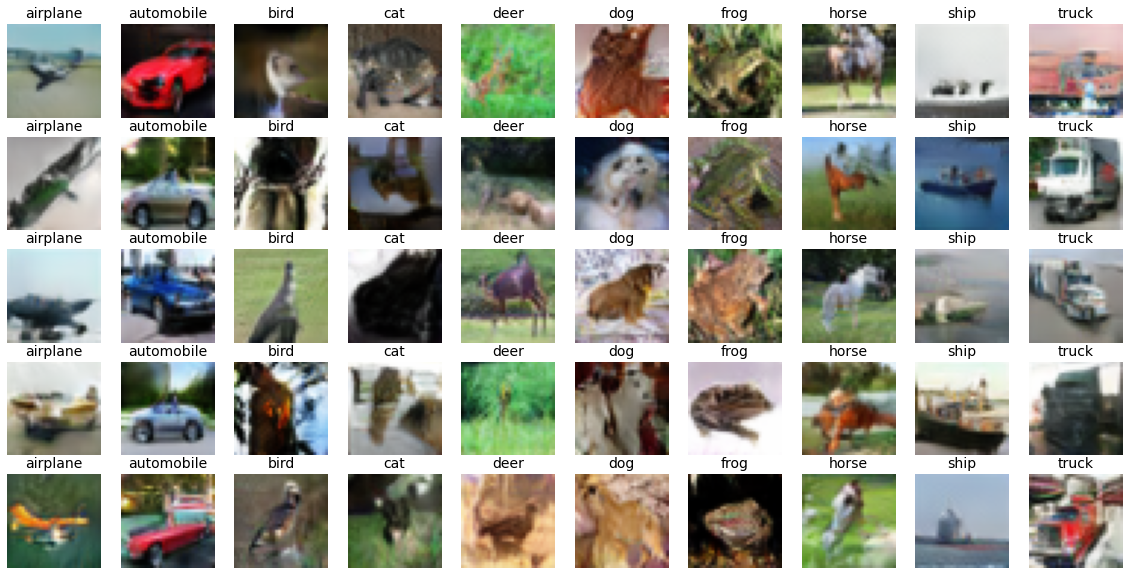

KeyboardInterrupt: 

In [7]:
tf.reset_default_graph()
Train()

Final Output:

![png](outputs/CSNGAN_PD/image_at_epoch_18350.png)
![png](outputs/CSNGAN_PD/image_at_epoch_18200.png)
![png](outputs/CSNGAN_PD/image_at_epoch_17400.png)
![png](outputs/CSNGAN_PD/CSNGAN_PD.gif)

I interrupted the training because this was actually run on a seperate notebook for about 8 hours. We managed to get to epoch 18650, with the best FID score reaching 20.852, and the best IS score reaching 8.4769.

As we can see, the quality of images generated are excellent, with the FID score and Inception Score being a very good indicator of the quality of the images generated. Additionally, with the conditionality added, the images generated are very similar to the images in the dataset, with the same colours and shapes.

We can see that the generated images on inanimate classes are actually a lot better than that of animate objects.

As we observe the 'truck' class, we can see that the generated images are very similar to the images in the dataset, with the same colours and shapes. This is also similar for the ships and automobiles.

Funnily enough, the generated images for the 'bird' class are actually very similar to the images in the dataset, with the same colours and shapes. This is also similar for the 'cat' and 'dog' classes.

Generally, I would say that the most consistent classes that perform well are the `frog`, `ship`, `truck`, `automobile`, while the most inconsistent classes are the `airplane`, `dog`, `cat`, and `deer`.

For the consistent classes, this is most likely due to the fact that they are inanimate objects, hence the average standard deviation in the shape is smaller than that of the animate objects. An example of this is the `ship` class, where the majority of the ship images are in water, with a blue background. As such, the feature detection within the ResBlock is able to draw out the features of the ship, and the generator is able to generate images that are similar to the images in the dataset. 

For the inconsistent classes, this is most likely due to the fact that they are animate objects, hence the average standard deviation in the shape is larger than that of the inanimate objects. An example of this is the `cat` class, where the majority of the cat images are in a grassy field, with a green background. As such, the feature detection within the ResBlock is not able to draw out the features of the cat, and the generator is not able to generate images that are similar to the images in the dataset.



## Final Model Analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

In [2]:
metric_list = ['fid','is_mean','gen','disc']
model_directory = 'training_info/'
model_names = [f for f in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, f))]
print(model_names)
def make_df( model_names,metric_list=metric_list):
    model_dict= {}
    metric_dict ={}
    for name in model_names:
        for metric in metric_list:
            if metric == 'gen' or metric== 'disc':
                metric_loss = metric+'_loss'
            else:
                metric_loss = metric
            # Read the data into a list of strings
            with open(f"training_info/{name}/{metric}/{metric_loss}.txt", "r") as file:
                data = file.readlines()

            # Split each string into two parts: the epoch and its value
            data = [line.strip().split(": ") for line in data]
            data = [(int(item[0].replace("epoch ", "")), float(item[1])) for item in data]

            df_name = metric+'_df'

            # Convert the list of tuples into a pandas dataframe
            df_name = pd.DataFrame(data, columns=["epoch", "value"])

            # Convert the "epoch" column from string to integer
            df_name["epoch"] = df_name["epoch"].astype(int)

            # Convert the "value" column from string to float
            df_name["value"] = df_name["value"].astype(float)

#             diff_1 = df_name['epoch'][0]
#             diff_2 = df_name['epoch'][1]

#             if diff_2 - diff_1 == 10:

#                 # Do not reindex if the epochs are already spaced by 10
#                 pass
#             else:
#                 # Create an index of epochs spaced by 10
#                 index = range(0, max(df_name["epoch"]) + 10, 10)

#                 # Reindex the dataframe with the new index, filling missing rows with NaN values
#                 df_name = df_name.set_index("epoch").reindex(index).reset_index()

            # Show the first 5 rows of the dataframe
            metric_dict[metric] = df_name
        comb_dict = pd.concat(metric_dict.values(), axis=1, keys=metric_dict.keys())
        comb_dict.columns = [' '.join(col).strip() for col in comb_dict.columns.values]
        comb_dict = comb_dict.drop(["is_mean epoch", "gen epoch", "disc epoch"], axis=1)
        comb_dict = comb_dict.rename(columns={"fid epoch": "epoch"})
        comb_dict = comb_dict.rename(columns=lambda x: x.strip(' value'))
        comb_dict = comb_dict.rename(columns={"poch": "epoch"})
#         comb_dict = comb_dict.rename(columns={"is_stdd": "is_stddev"})
#         comb_dict = comb_dict[comb_dict['epoch']]
        model_dict[name] =  comb_dict
    return model_dict
    
metric_list = metric_list[:-2]
model_dict = make_df(model_names= model_names)
csngan_family = make_df(model_names=['CSNGAN','CSNGAN_OLS','CSNGAN_PD'])
sngan_family = make_df(model_names=['SNGAN','SNGAN_OLS'])


['SNGAN', 'WGAN_SyncBN', 'CSNGAN_PD', 'CSNGAN_OLS', 'WGAN_GP', 'SNGAN_OLS', 'CSNGAN']


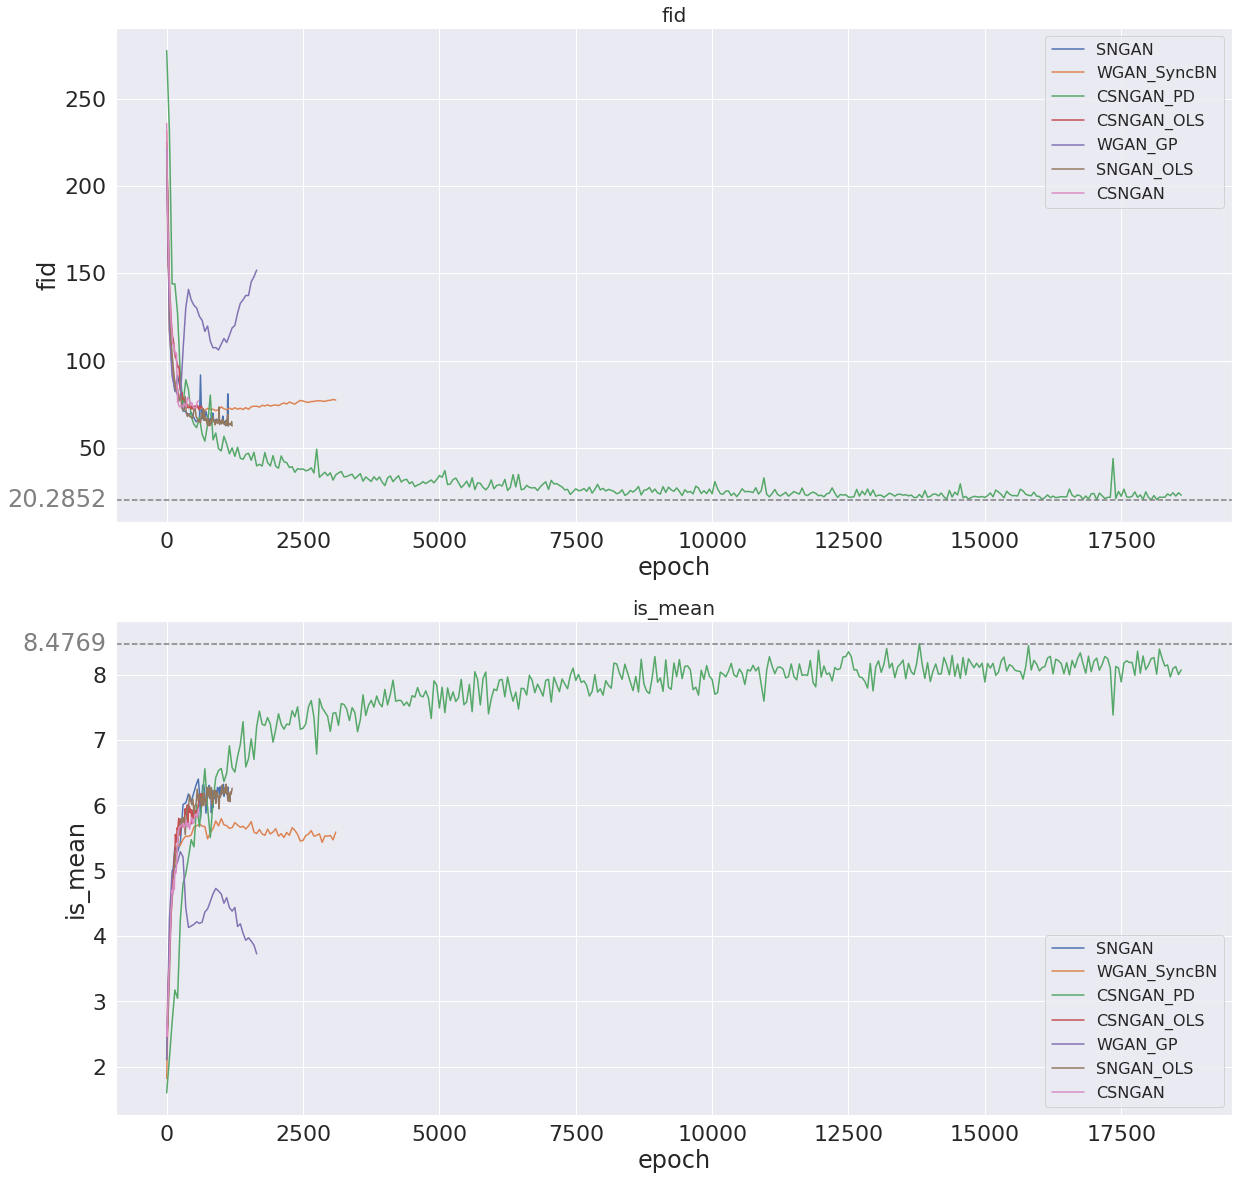

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_family(model_dict,c_map,size,font):
    sns.set_palette(c_map)
    sns.set(font_scale=2)
    fig, axs = plt.subplots(len(metric_list), 1, figsize=(size, size))
    for i, metric in enumerate(metric_list):
        min_value = float('inf')
        max_value = float('-inf')

        for model_name, df in model_dict.items():
            sns.lineplot(x='epoch', y=metric, data=df, ax=axs[i], label=model_name)
            min_value = min(min_value, df[metric].min())
            max_value = max(max_value, df[metric].max())

        if metric == 'fid':
            axs[i].axhline(y=min_value, color='gray', linestyle='--')
            trans = transforms.blended_transform_factory(
            axs[i].get_yticklabels()[0].get_transform(), axs[i].transData)
            axs[i].text(0,min_value, "{:.4f}".format(min_value), color="gray", transform=trans, 
                    ha="right", va="center")
            
        else:
            axs[i].axhline(y=max_value, color='gray', linestyle='--')
            trans = transforms.blended_transform_factory(
            axs[i].get_yticklabels()[0].get_transform(), axs[i].transData)
            axs[i].text(0,max_value, "{:.4f}".format(max_value), color="gray", transform=trans, 
                    ha="right", va="center")
        axs[i].set_title(metric,fontsize=20)
#         axs[i].set_ylim(bottom=limit[i])
        axs[i].legend(fontsize=font)
    plt.show()

    
    
plot_family(model_dict,'colorblind6',20,16)


The reason why I ran the CSGAN_PD for 8 hours is because I wanted to see if the FID score would improve. I was right, as the FID score improved from 50-ish to 20.2852, and the Inception Score improved from 6.2 to 8.4769, at epoch ~ 1250. This is because the CSNGAN_PD is a more complex model, hence it takes longer to train. However, the CSNGAN_PD is able to generate images that are more similar to the images in the dataset, hence the FID score and Inception Score are better.

As a result, I would say that the CSNGAN_PD is a better model than the CSNGAN_OLS, as it is able to generate images that are more similar to the images in the dataset, hence the FID score and Inception Score are better.

In regards to the WGANs, we can see that both implementations of the WGAN perform poorly. This is because the WGAN is a very unstable model, and it is very difficult to train. As a result, the WGAN is not able to generate images that are similar to the images in the dataset, hence the FID score and Inception Score are worse.



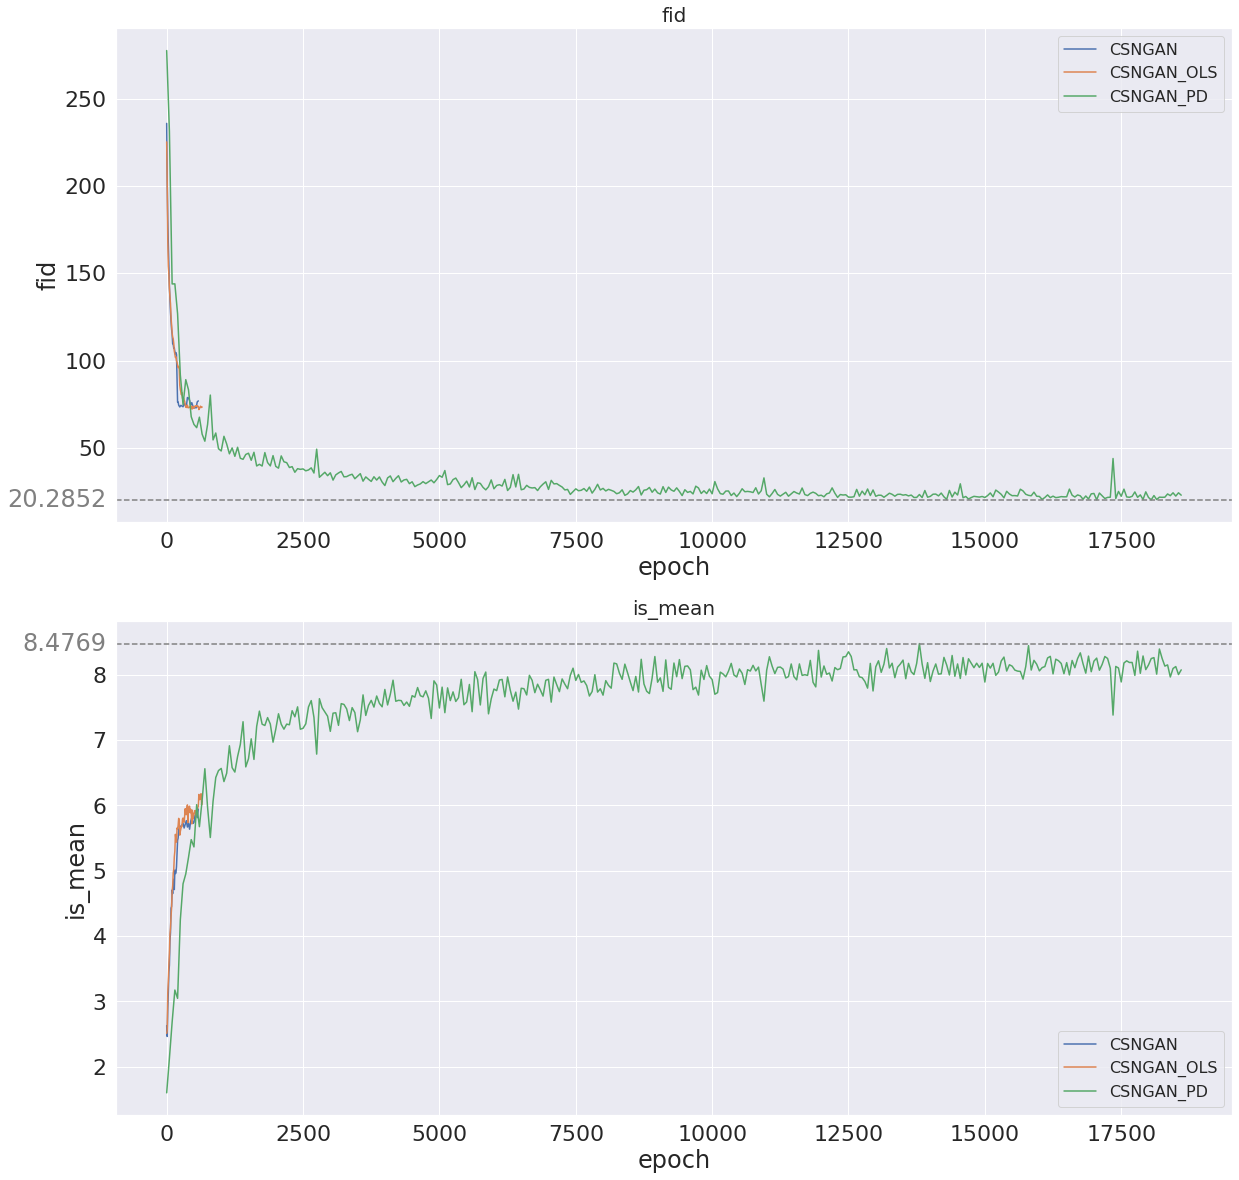

In [4]:
plot_family(csngan_family,'colorblind',20,16)


We can see that the One Sided Label Smoothing is able to generate images that are more similar to the images in the dataset, hence the FID score and Inception Score are better. However, the CSNGAN_PD is able to generate images that are more similar to the images in the dataset, hence the FID score and Inception Score are better. As such, I would say that the CSNGAN_PD is a better model than the CSNGAN_OLS. 

Nonetheless, both models still perform better than the original CSNGAN.

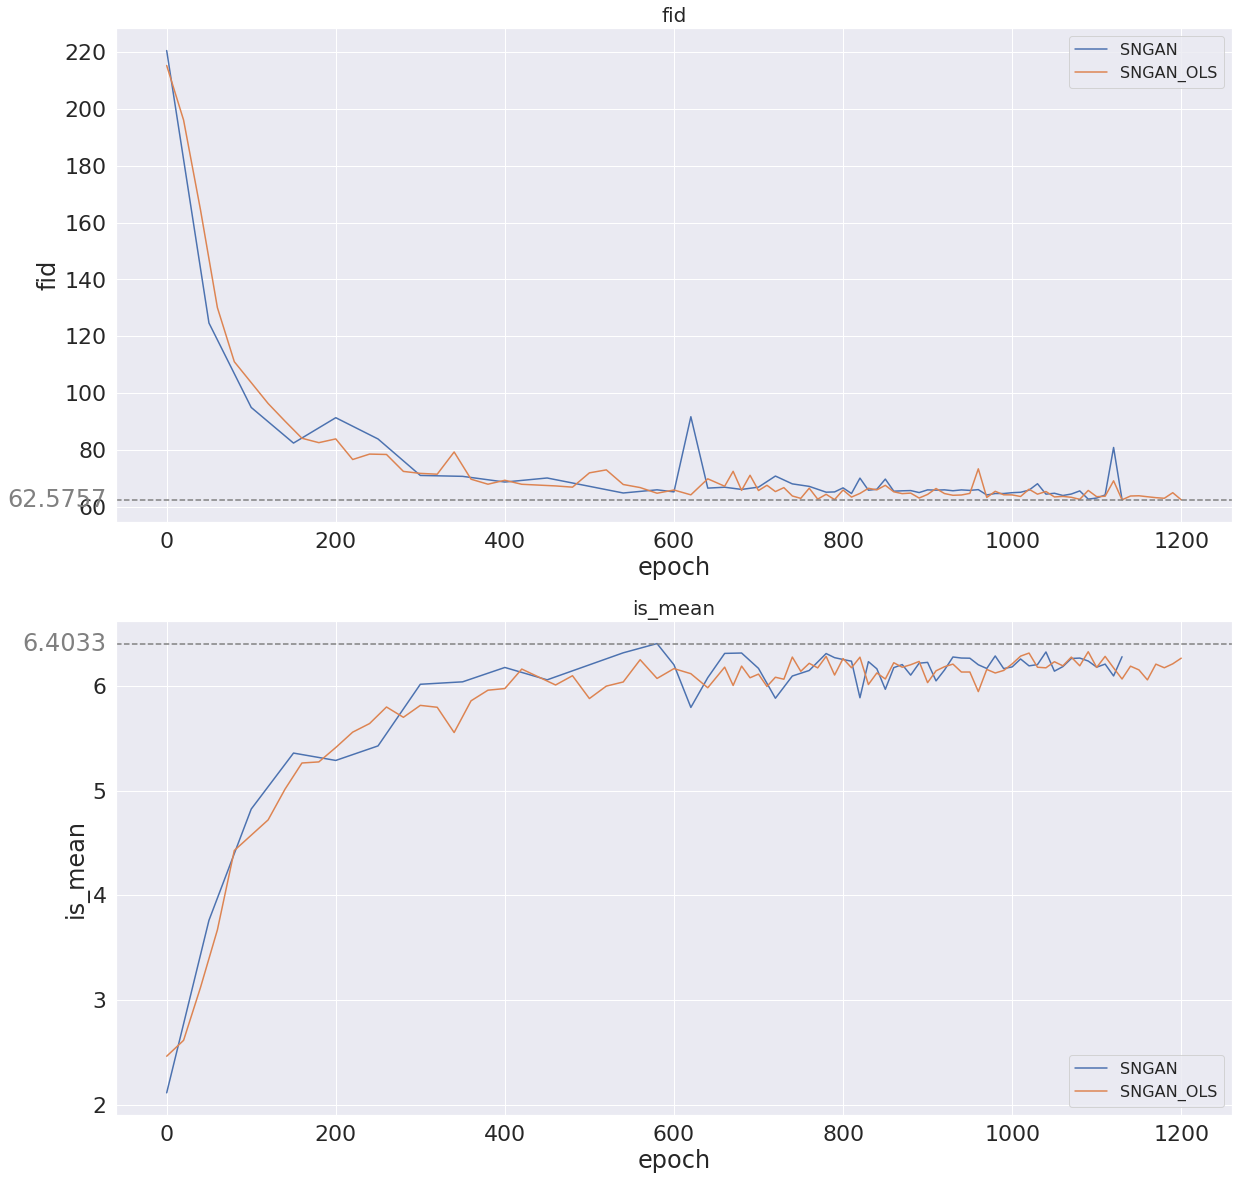

In [5]:
plot_family(sngan_family,'colorblind',20,16)

However, for the original SNGAN, we can see that there is actually no difference in the performance of the SNGAN vs SNGAN_OLS, with the FID and Inception Score for both models being roughly the same. 

## Conclusion

The exploration and analysis of the 7 models for the cifar-10 dataset revealed that the CSNGAN with Project Discriminator and Conditional Batch Normalisation (CSNGAN_PD) model was the best performing model. This was determined by evaluating the models based on the Fréchet Inception Distance (FID) score, which measures the similarity between the generated images and real images, and Inception Score (IS), which measures the quality of the generated images.

The WGAN_GP and WGAN_SyncBatchNorm models performed similarly and had a higher FID score and IS compared to the other models. The SNGAN model showed some improvement in the FID score and IS compared to the WGAN models but was still not as good as the CSNGAN models. The SNGAN_OLS model showed an improvement in the FID score and IS, but still was not as good as the CSNGAN models.

The CSNGAN and CSNGAN_OLS models showed slight improvement in the FID score and IS compared to the WGAN models and SNGAN models. However, the best performance was achieved with the CSNGAN_PD model, which had the lowest FID score and IS among the models.

In conclusion, the CSNGAN_PD model demonstrated the best performance in terms of generating high-quality images that are similar to real images in the cifar-10 dataset. This shows the effectiveness of combining the project discriminator and conditional batch normalisation techniques in improving the performance of the generative models.